# ELBO for Mr.ASH penalized regression

- toc: true
- badges: true
- comments: true
- categories: [trend-filtering, mr-ash, regression-methods]
- slug: mrash-penalized-trend-filtering-elbo

### About

In this demo, I illustrate the convergence of three different algorithms for using Mr.ASH in sparse multiple linear regression and trendfiltering. Given response variables $\mathbf{y}$ for $N$ samples and explanatory variables $\mathbf{X}$ for $P$ variables (generally $N \lt P$). We will perform a sparse multiple regression using the adaptive shrinkage prior (Mr.ASH),

$\mathbf{y} = \mathbf{X}\mathbf{b} + \mathbf{e}$,

$\mathbf{e} \sim \mathcal{N}\left(\mathbf{0} \mid \sigma^2 I_n \right)$,

$\mathbf{b} \sim p\left(\mathbf{b} \mid \boldsymbol{\theta}_1\right)$.

$p\left(b_i \mid \boldsymbol{\theta}_1\right) = \sum_{k=1}^{K} w_k \mathcal{N}\left(b_i \mid \mu_k, \sigma_k^2\right)$ with a constraint $\sum_{k=1}^{K} \pi_k = 1$. 

We assume $\sigma_k$ is known and will estimate ($\mathbf{b}, w_k, \sigma^2)$ from the data.


Here, I will compare three methods:
 - **mr.ash.alpha.** Co-ordinate ascent algorithm for maximizing ELBO (as implemented in `mr.ash.alpha`; [Github](https://github.com/stephenslab/mr.ash.alpha))
 - **PLR.** Penalized linear regression using gradient descent (L-BFGS-B) algorithm (as implemented in `mr.ash.pen`; [Github](https://github.com/banskt/mr-ash-pen)).
 - **PLR-EM.** Hybrid algorithm which iterates between (i) estimating $\mathbf{b}$ by minimizing PLR objective (approzimate E-Step), and (ii) estimating $\mathbf{w}$ and $\sigma^2$ by maximizing ELBO (approximate M-step).

I will use the ELBO at each iteration for comparing the methods, although it is to be noted that the objective function for PLR is different.

In [1]:
#collapse-hide

import numpy as np
from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')


def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2):
    w = np.zeros(k)
    w[0] = 0.0
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, bhat, 
                         intercept = 0, title = None):
    ypred = np.dot(Xtest, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    
def plot_convergence(objs, methods, nwarm):
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(111)

    objmin  = np.min([np.min(x) for x in objs])

    for obj, method, iteq in zip(objs, methods, kinit):
        ax1.plot(range(iteq, len(obj) - 1), np.log10(obj[iteq:-1] - objmin), label = method)
    ax1.legend()

    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("log( max(ELBO) - ELBO )")

    plt.show()
    return

def plot_trendfilter_mrashpen(X, y, beta, ytest, bhat,
                              intercept = 0, title = None):
    n = y.shape[0]
    p = X.shape[1]

    ypred = np.dot(X, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(np.arange(n), ytest, edgecolor = 'black', facecolor='white', label="ytest")
    ax1.plot(np.arange(n), ypred, label=title)
    ax1.legend()
    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("y")

    ax2.scatter(np.arange(p), beta, edgecolor = 'black', facecolor = 'white', label = "btrue")
    ax2.scatter(np.arange(p), bhat, s = 10, color = 'firebrick', label = title)
    ax2.legend()
    ax2.set_xlabel("Sample index")
    ax2.set_ylabel("b")
    
    if title is not None:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()

### Linear model with n < p

Generate data with $N = 200$ and $P = 2000$

In [2]:
#collapse-hide

n = 200
p = 2000
p_causal = 20
pve = 0.7
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.0, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

Run the three methods

In [3]:
#collapse-show

'''
PLR
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 1)

'''
PLR-EM
'''
plr_eb = ebfit(X, y, sk, wk, binit = None, s2init = 1, maxiter = 200, qb_maxiter = 100)

'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = np.zeros(p), winit = wk, s2init = 1)

Mr.ASH terminated at iteration 203.


Here we plot the fits. On the left panel I show the predicted of $\mathbf{y}_{\mathrm{test}}$ by the different methods. On the right panel, I compare the predicted coefficients with their true values. At the bottom, I show the convergence of the different methods against the number of iteration. Each iteration corresponds to update of $\mathbf{b}$.

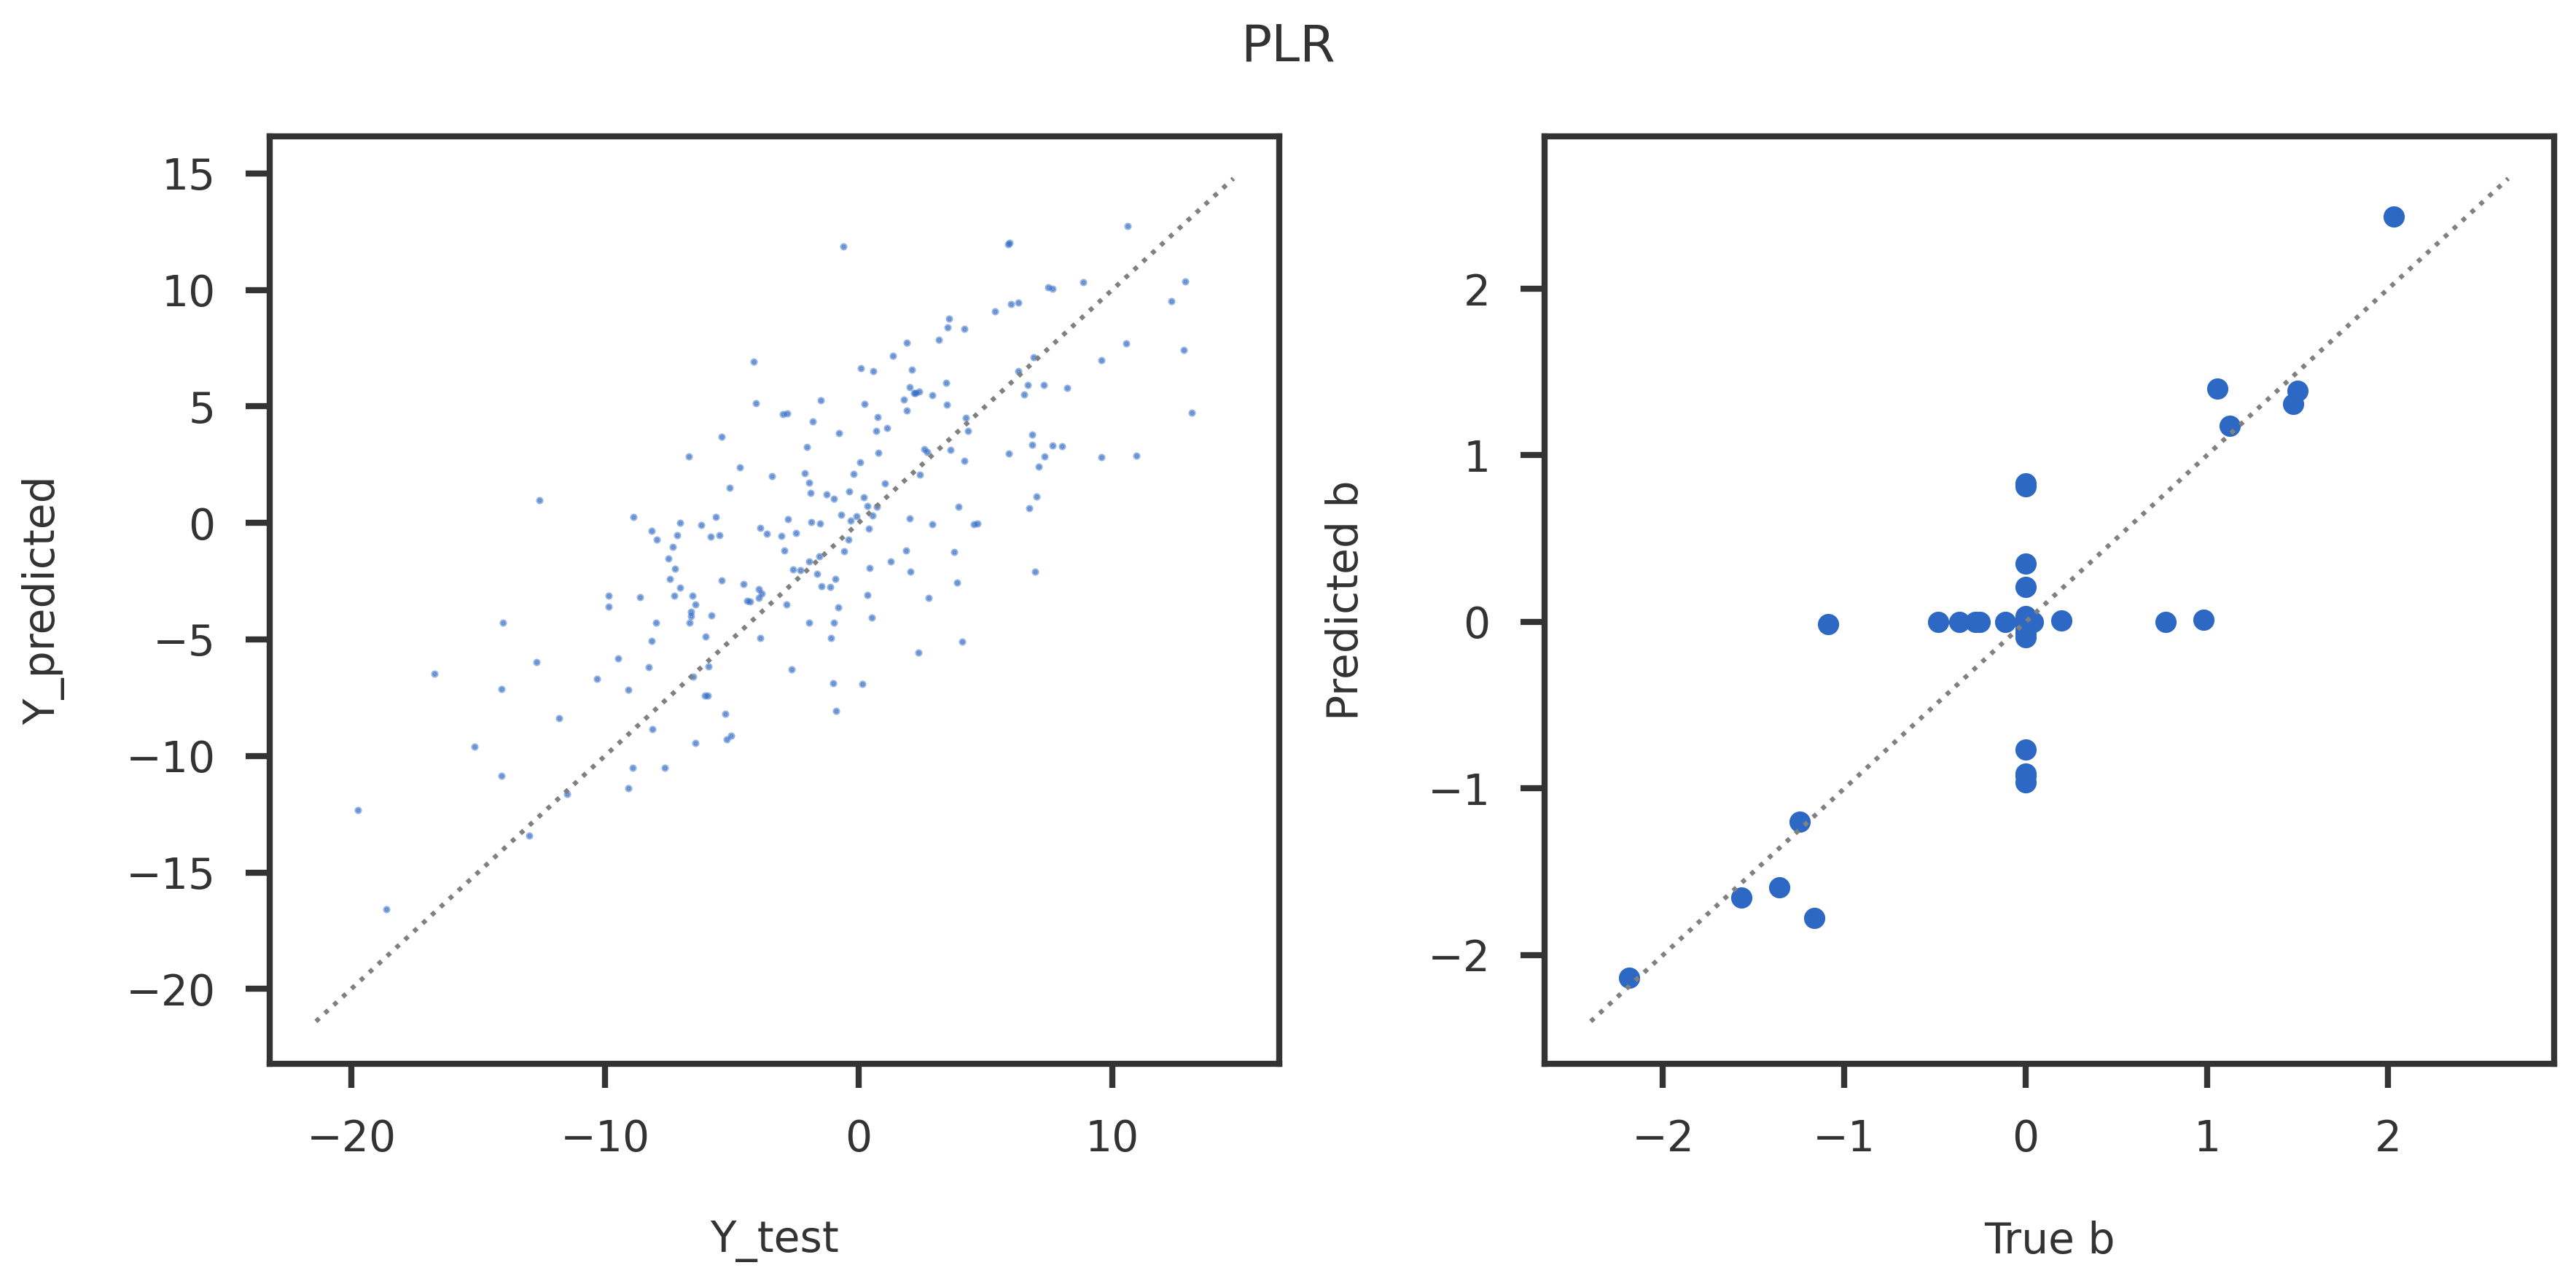

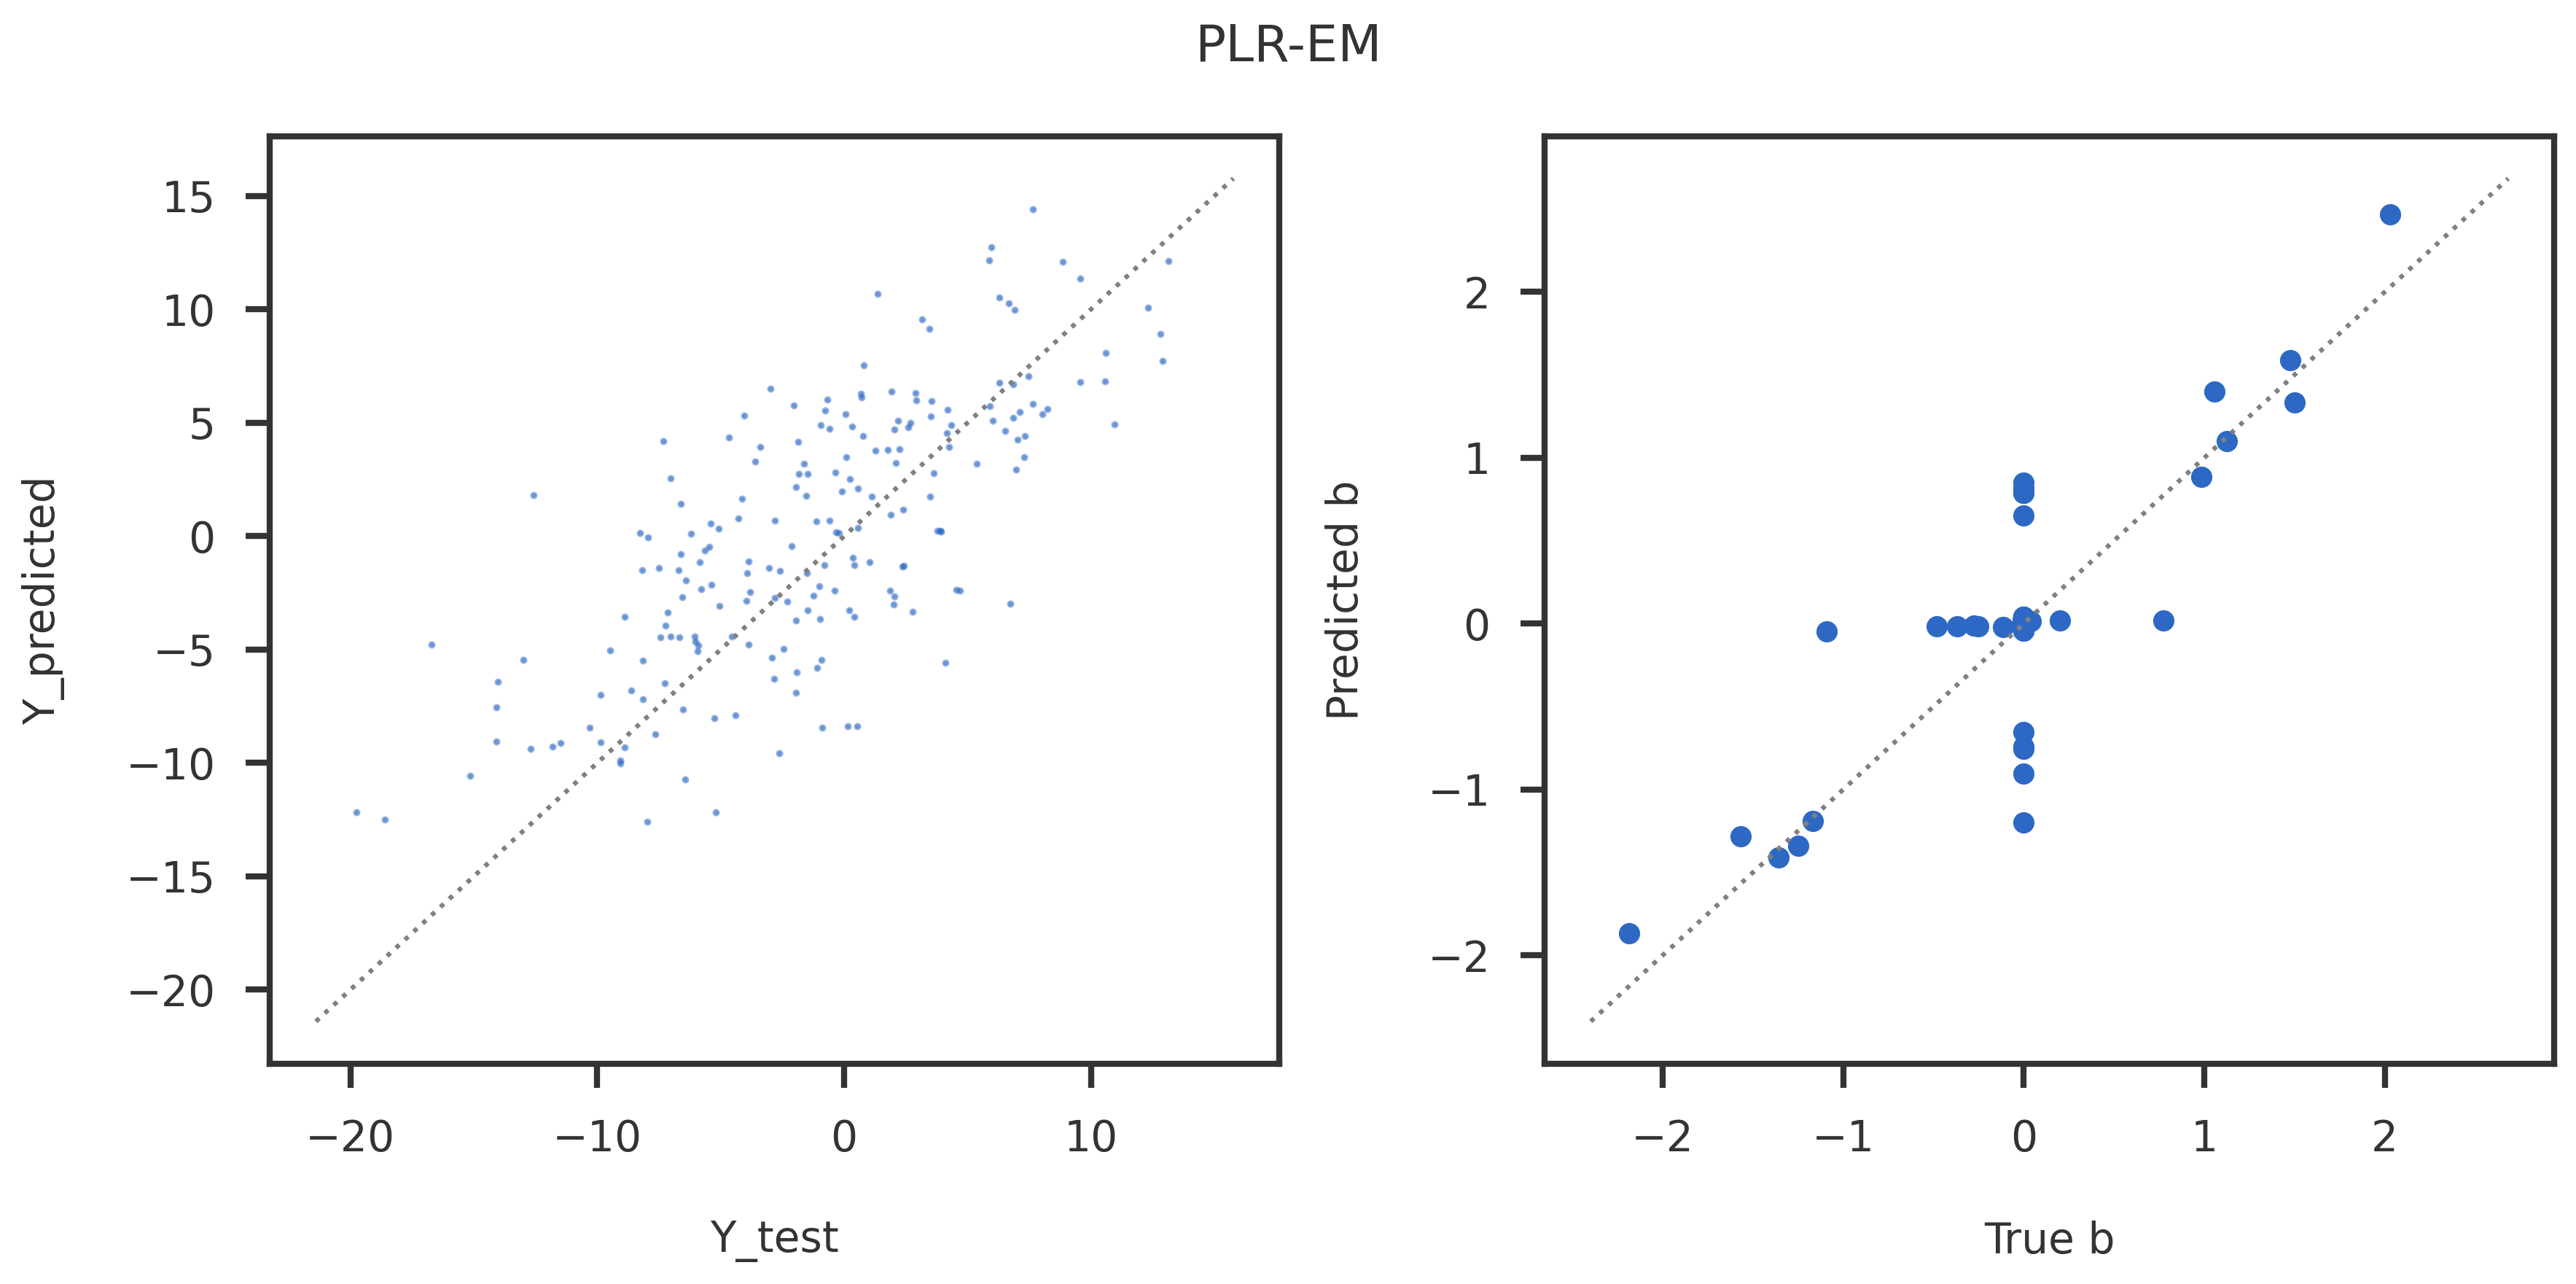

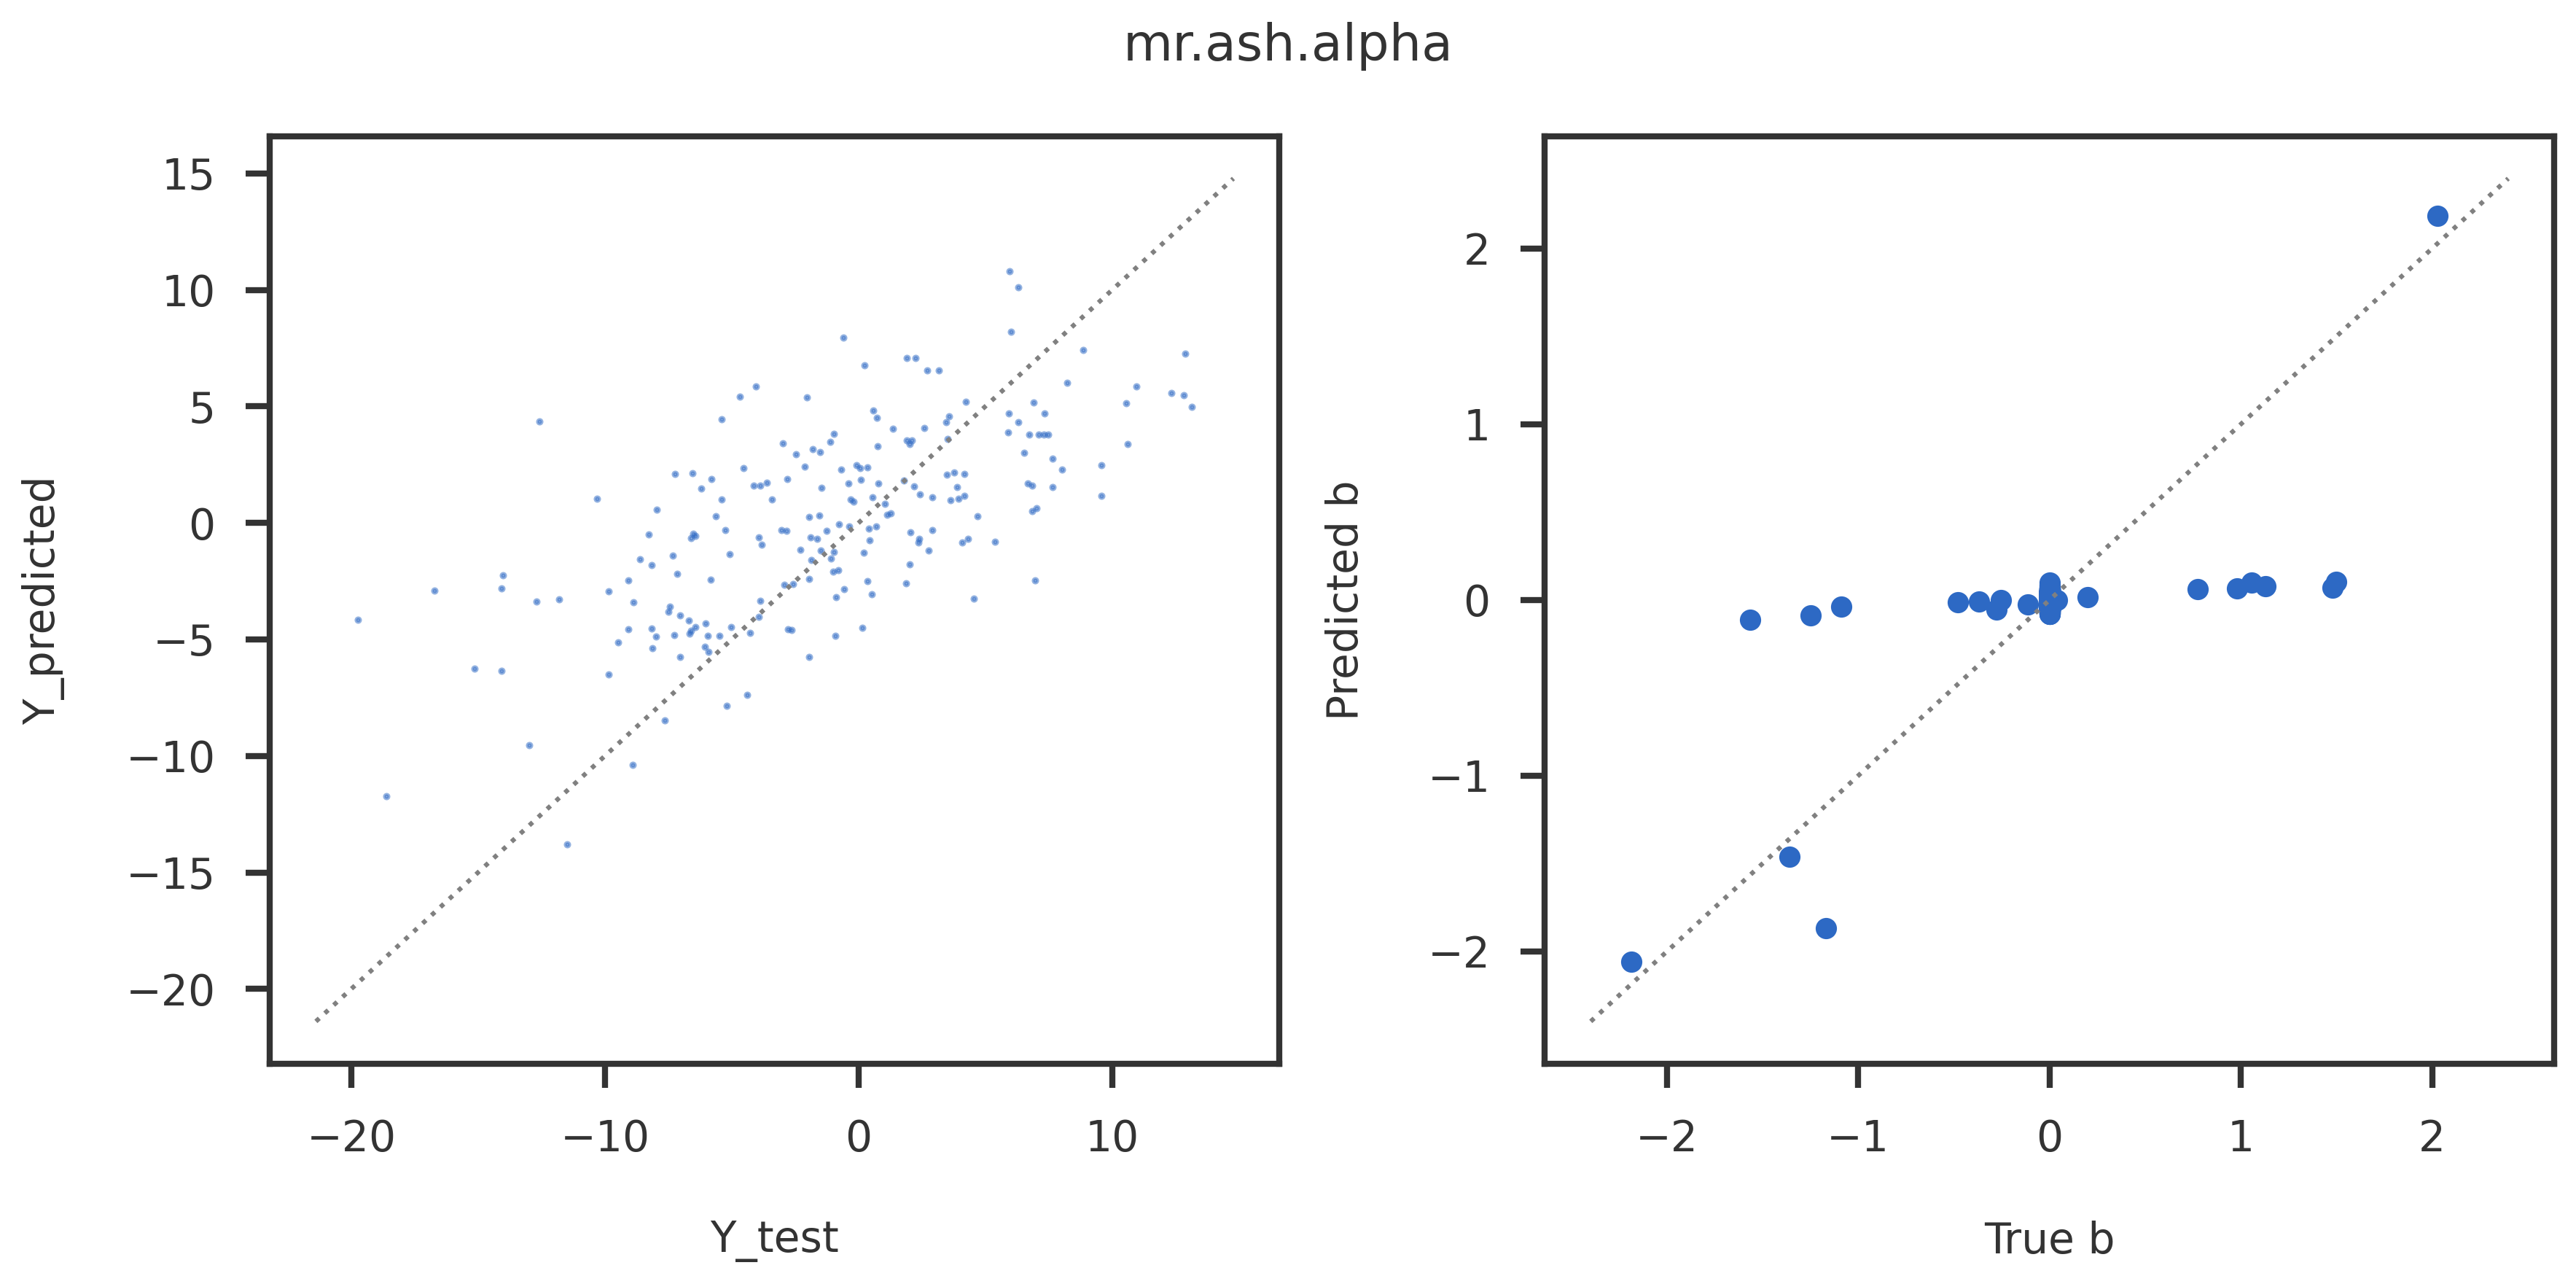

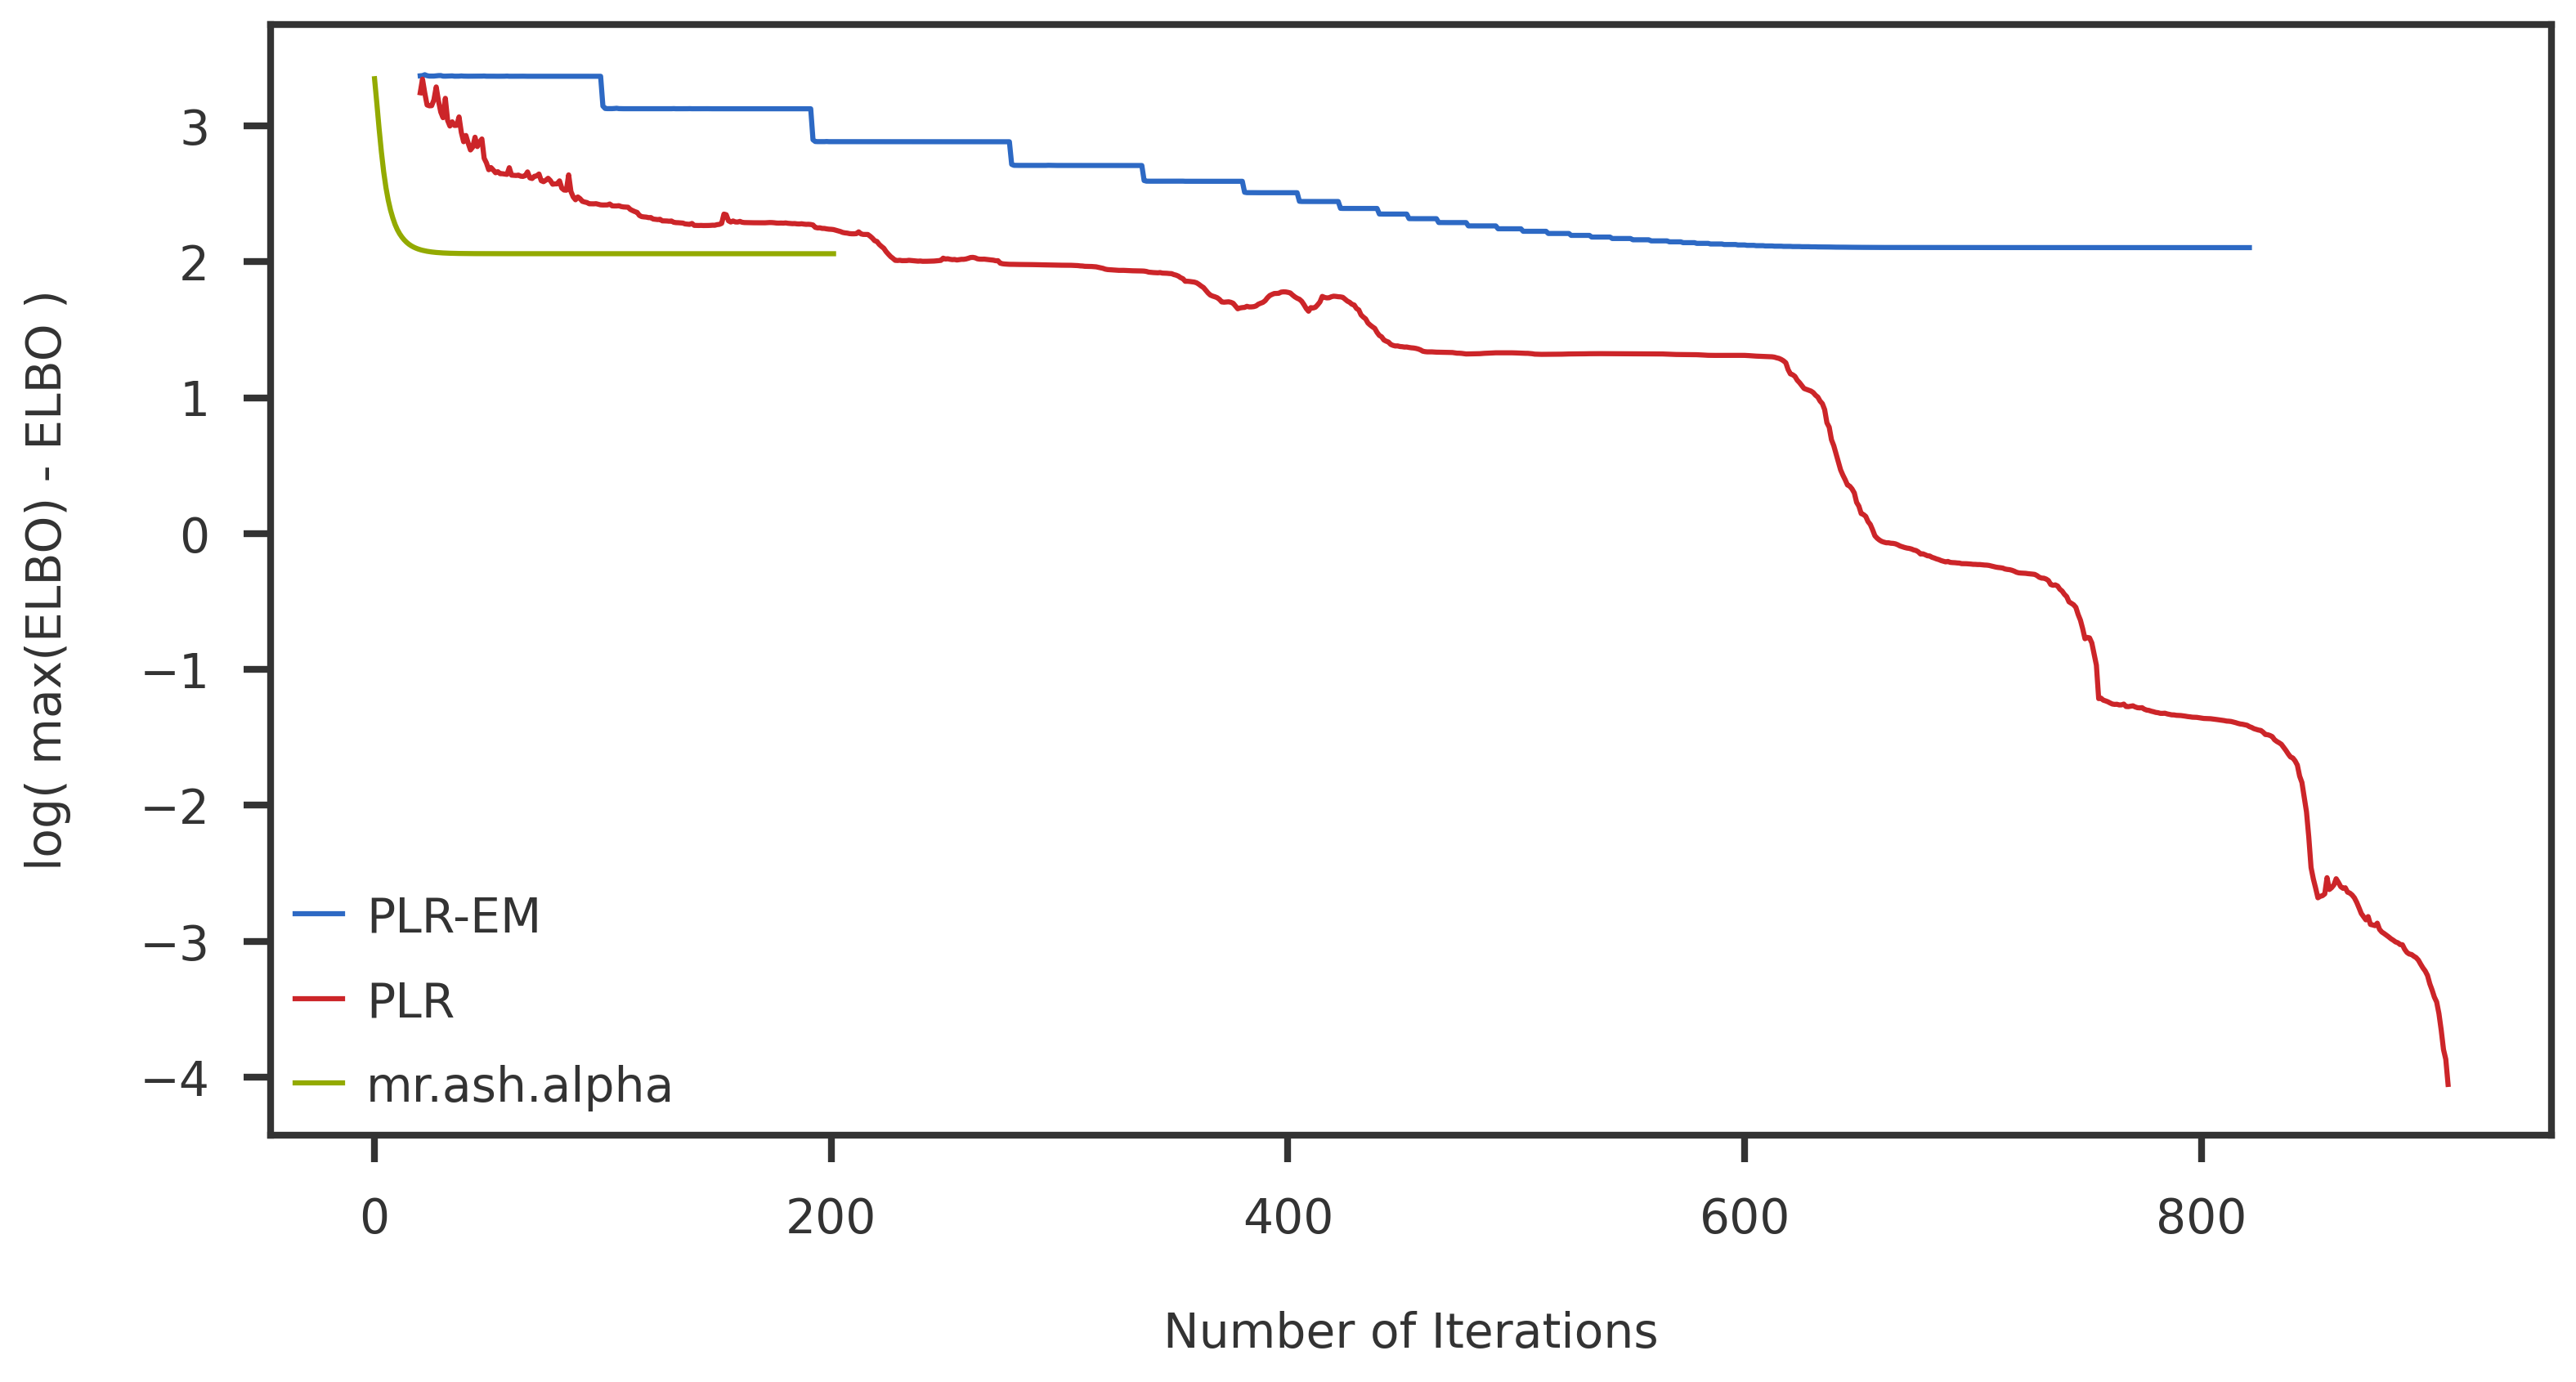

In [4]:
#collapse-hide

plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'PLR')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'PLR-EM')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')

kinit   = [20, 20, 0]
objs    = [plr_eb.elbo_path, plr_lbfgs.elbo_path, mrash_r.obj_path]
methods = ["PLR-EM", "PLR", "mr.ash.alpha"]
plot_convergence(objs, methods, kinit)

### Linear model with n < p and correlated X

Mr.ASH terminated at iteration 639.


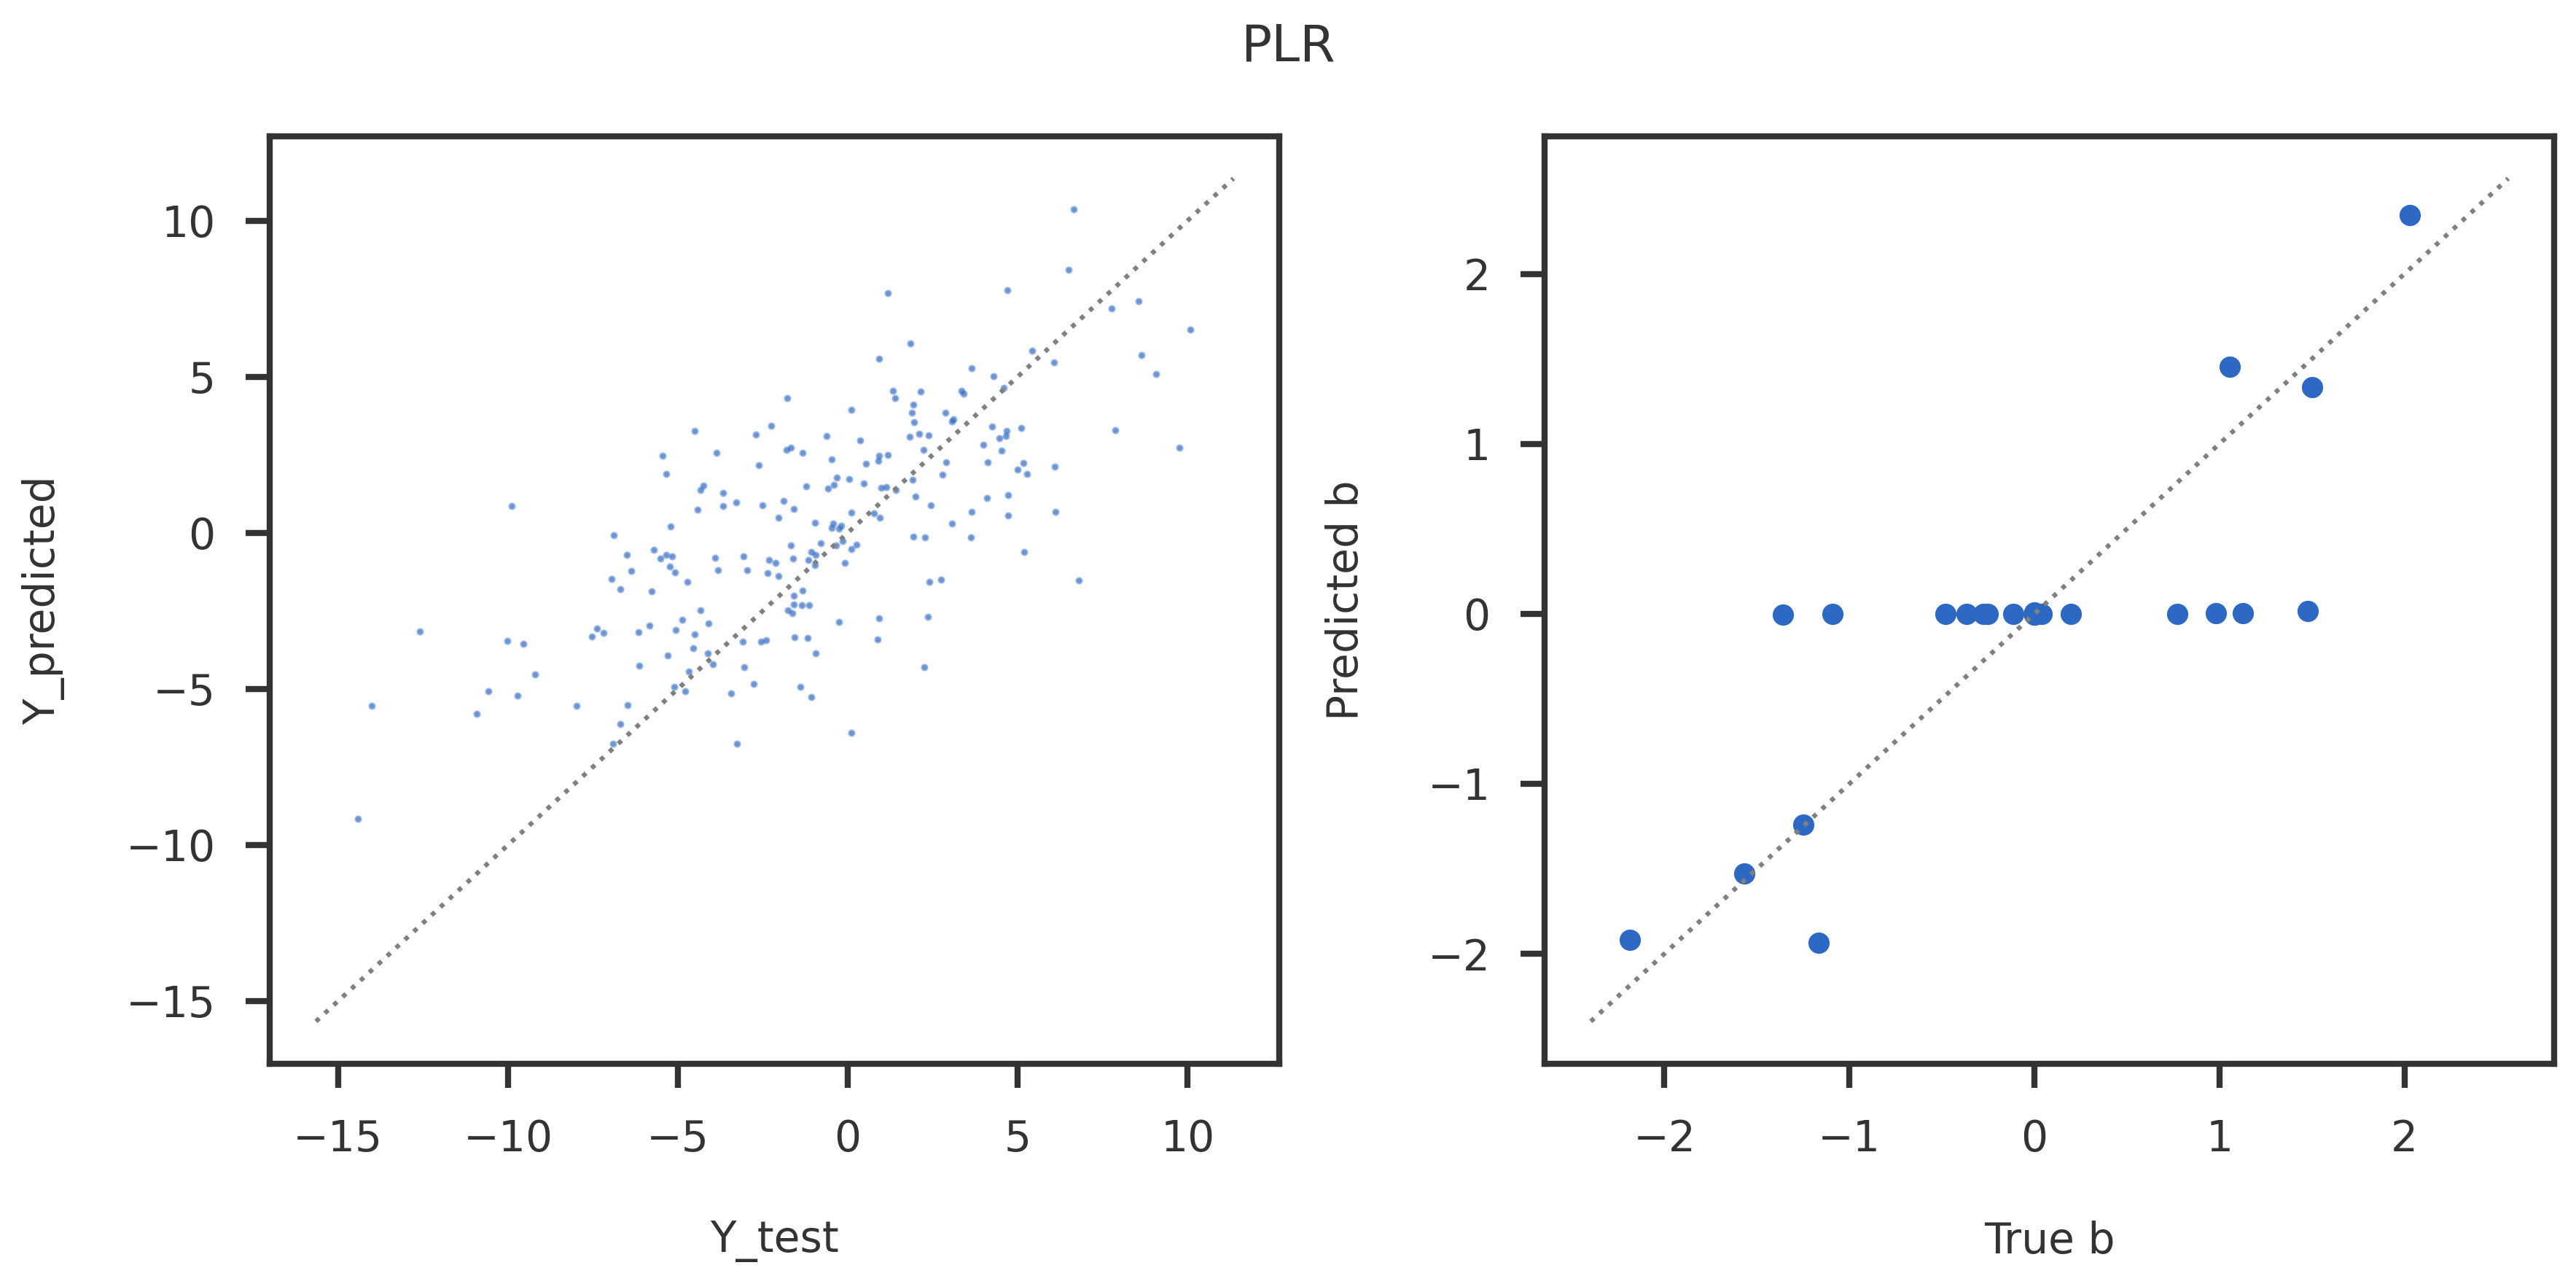

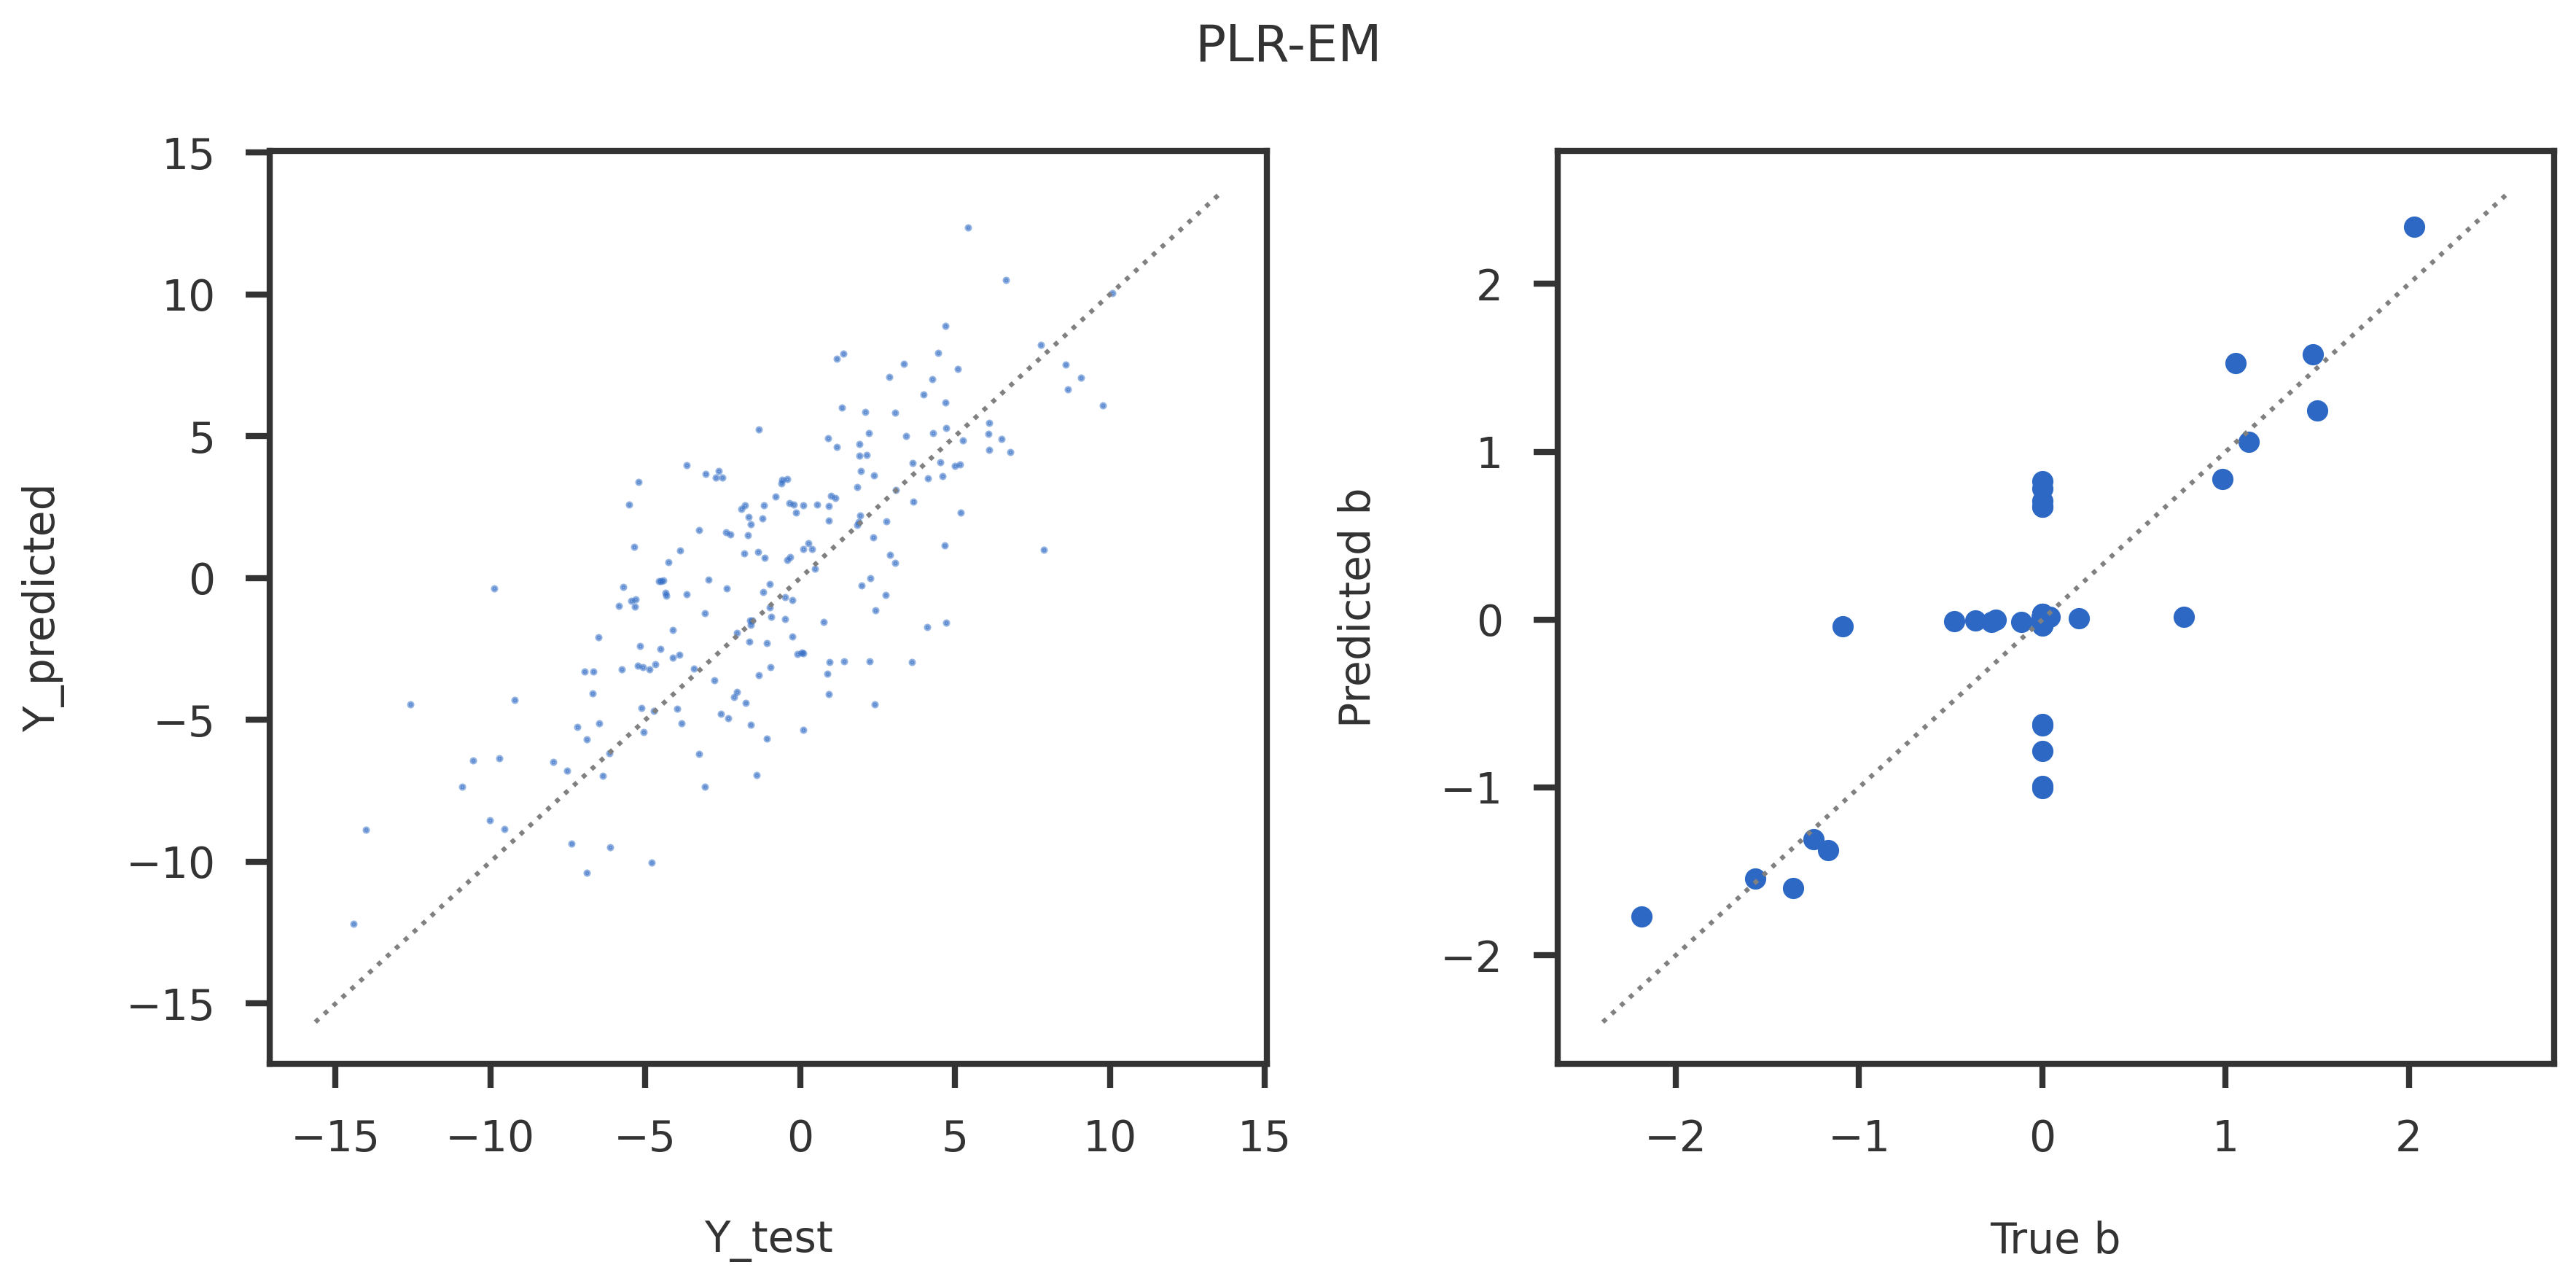

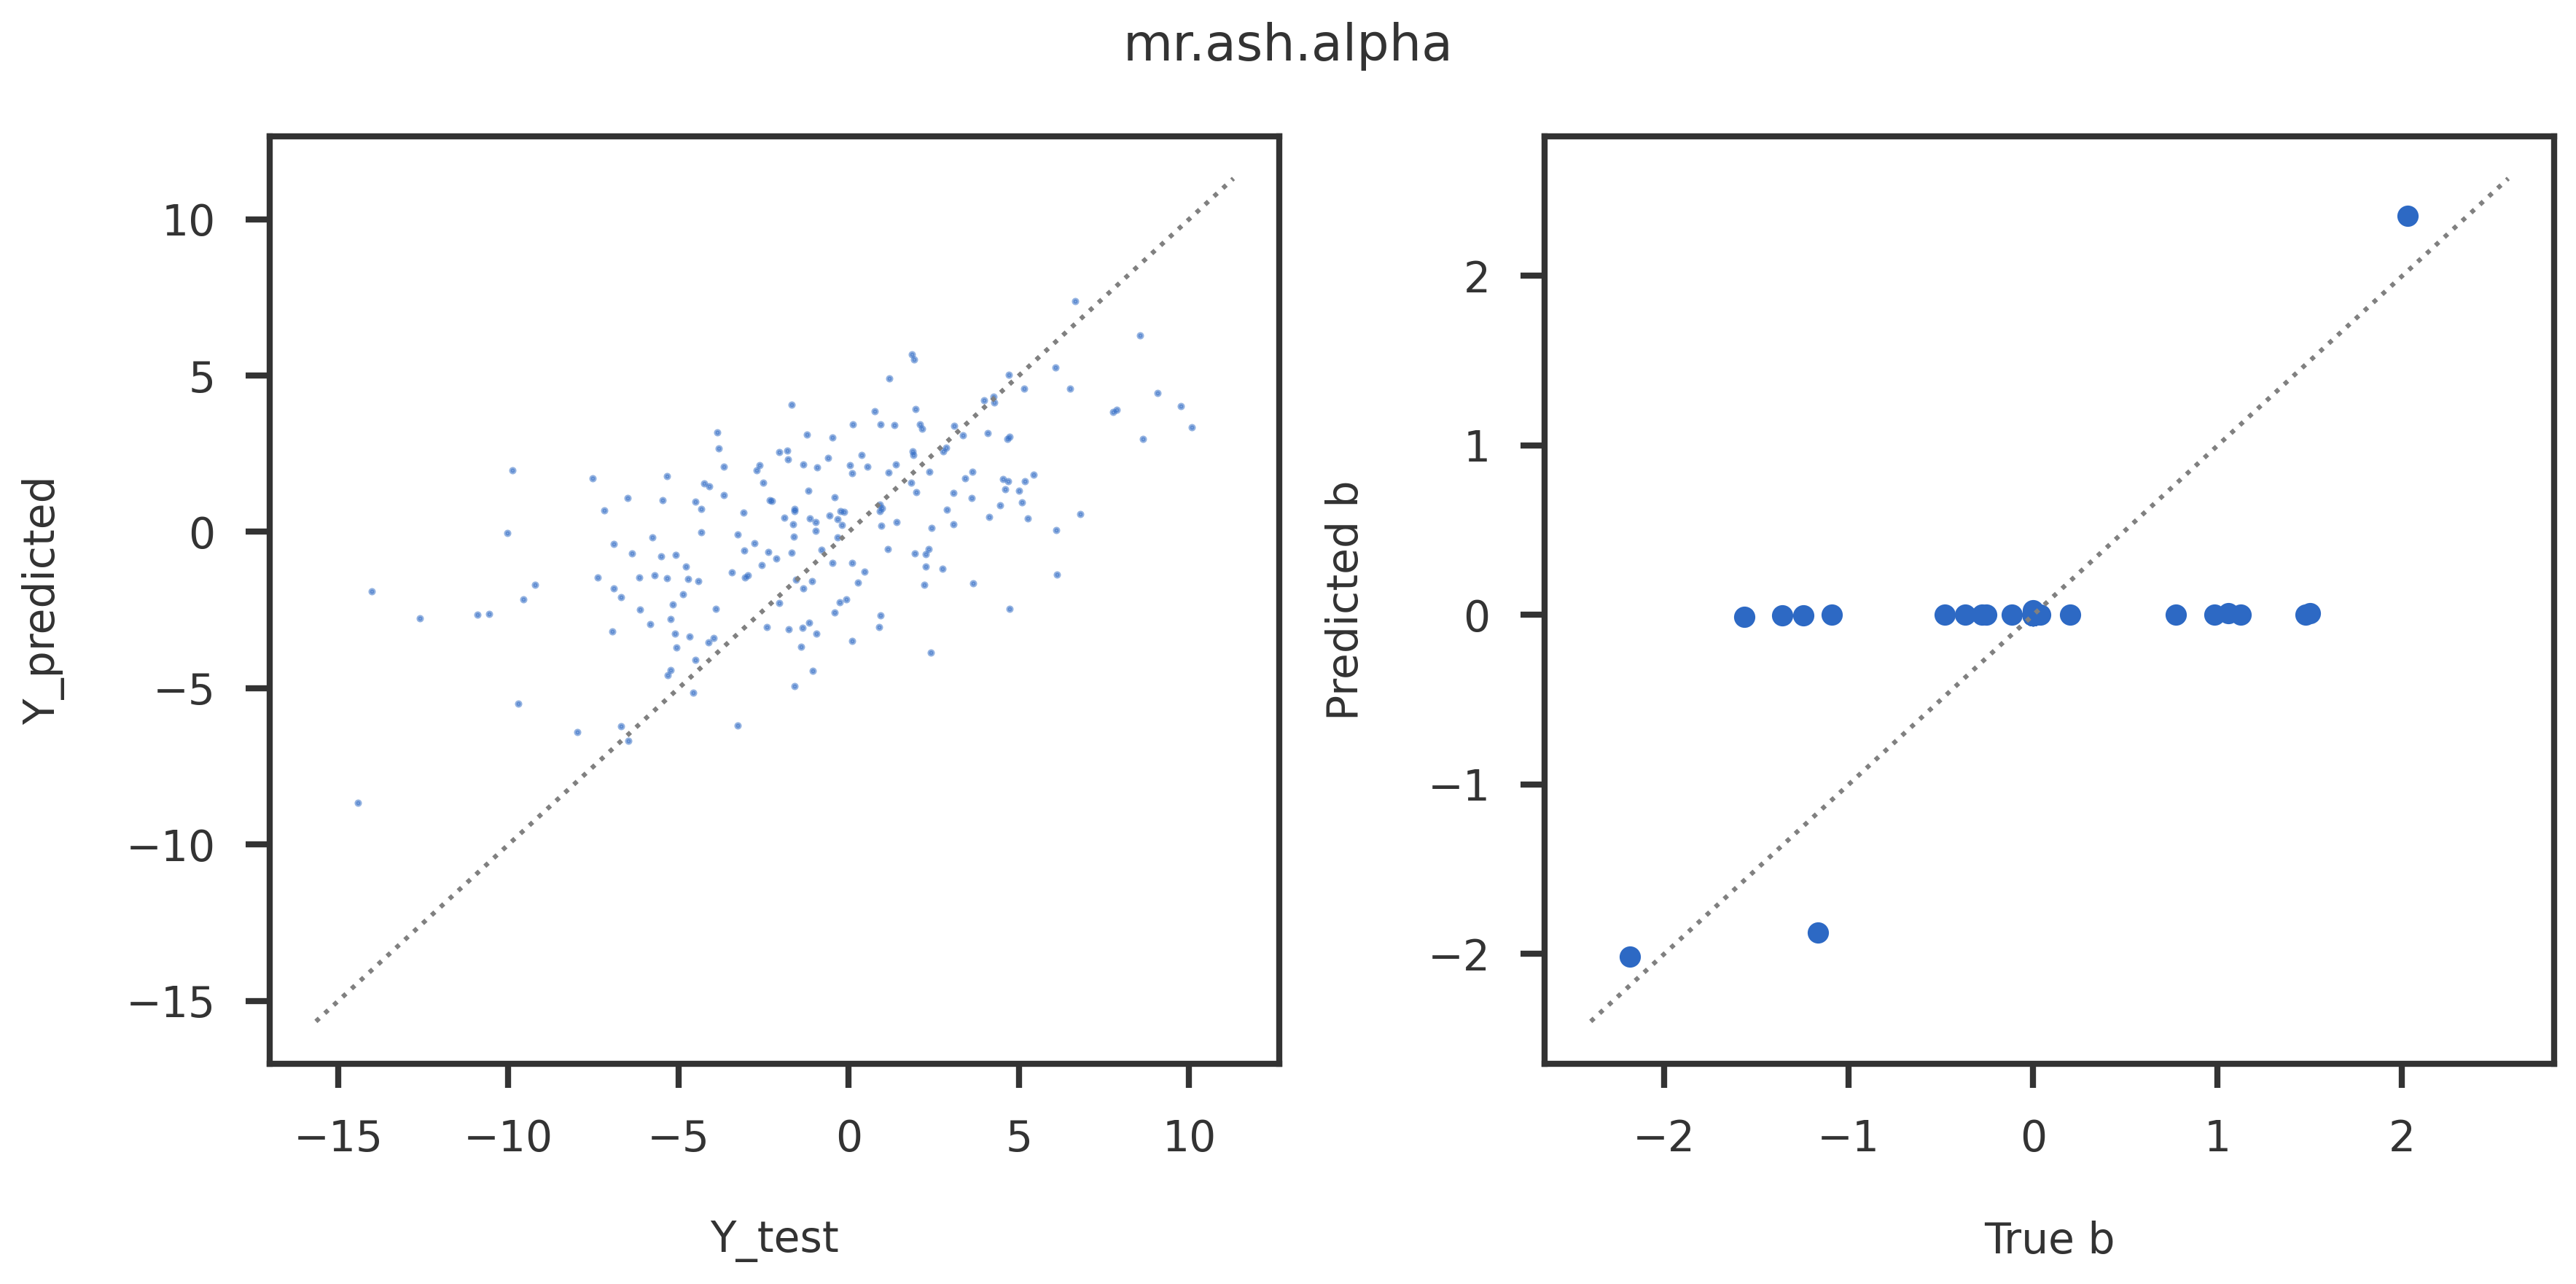

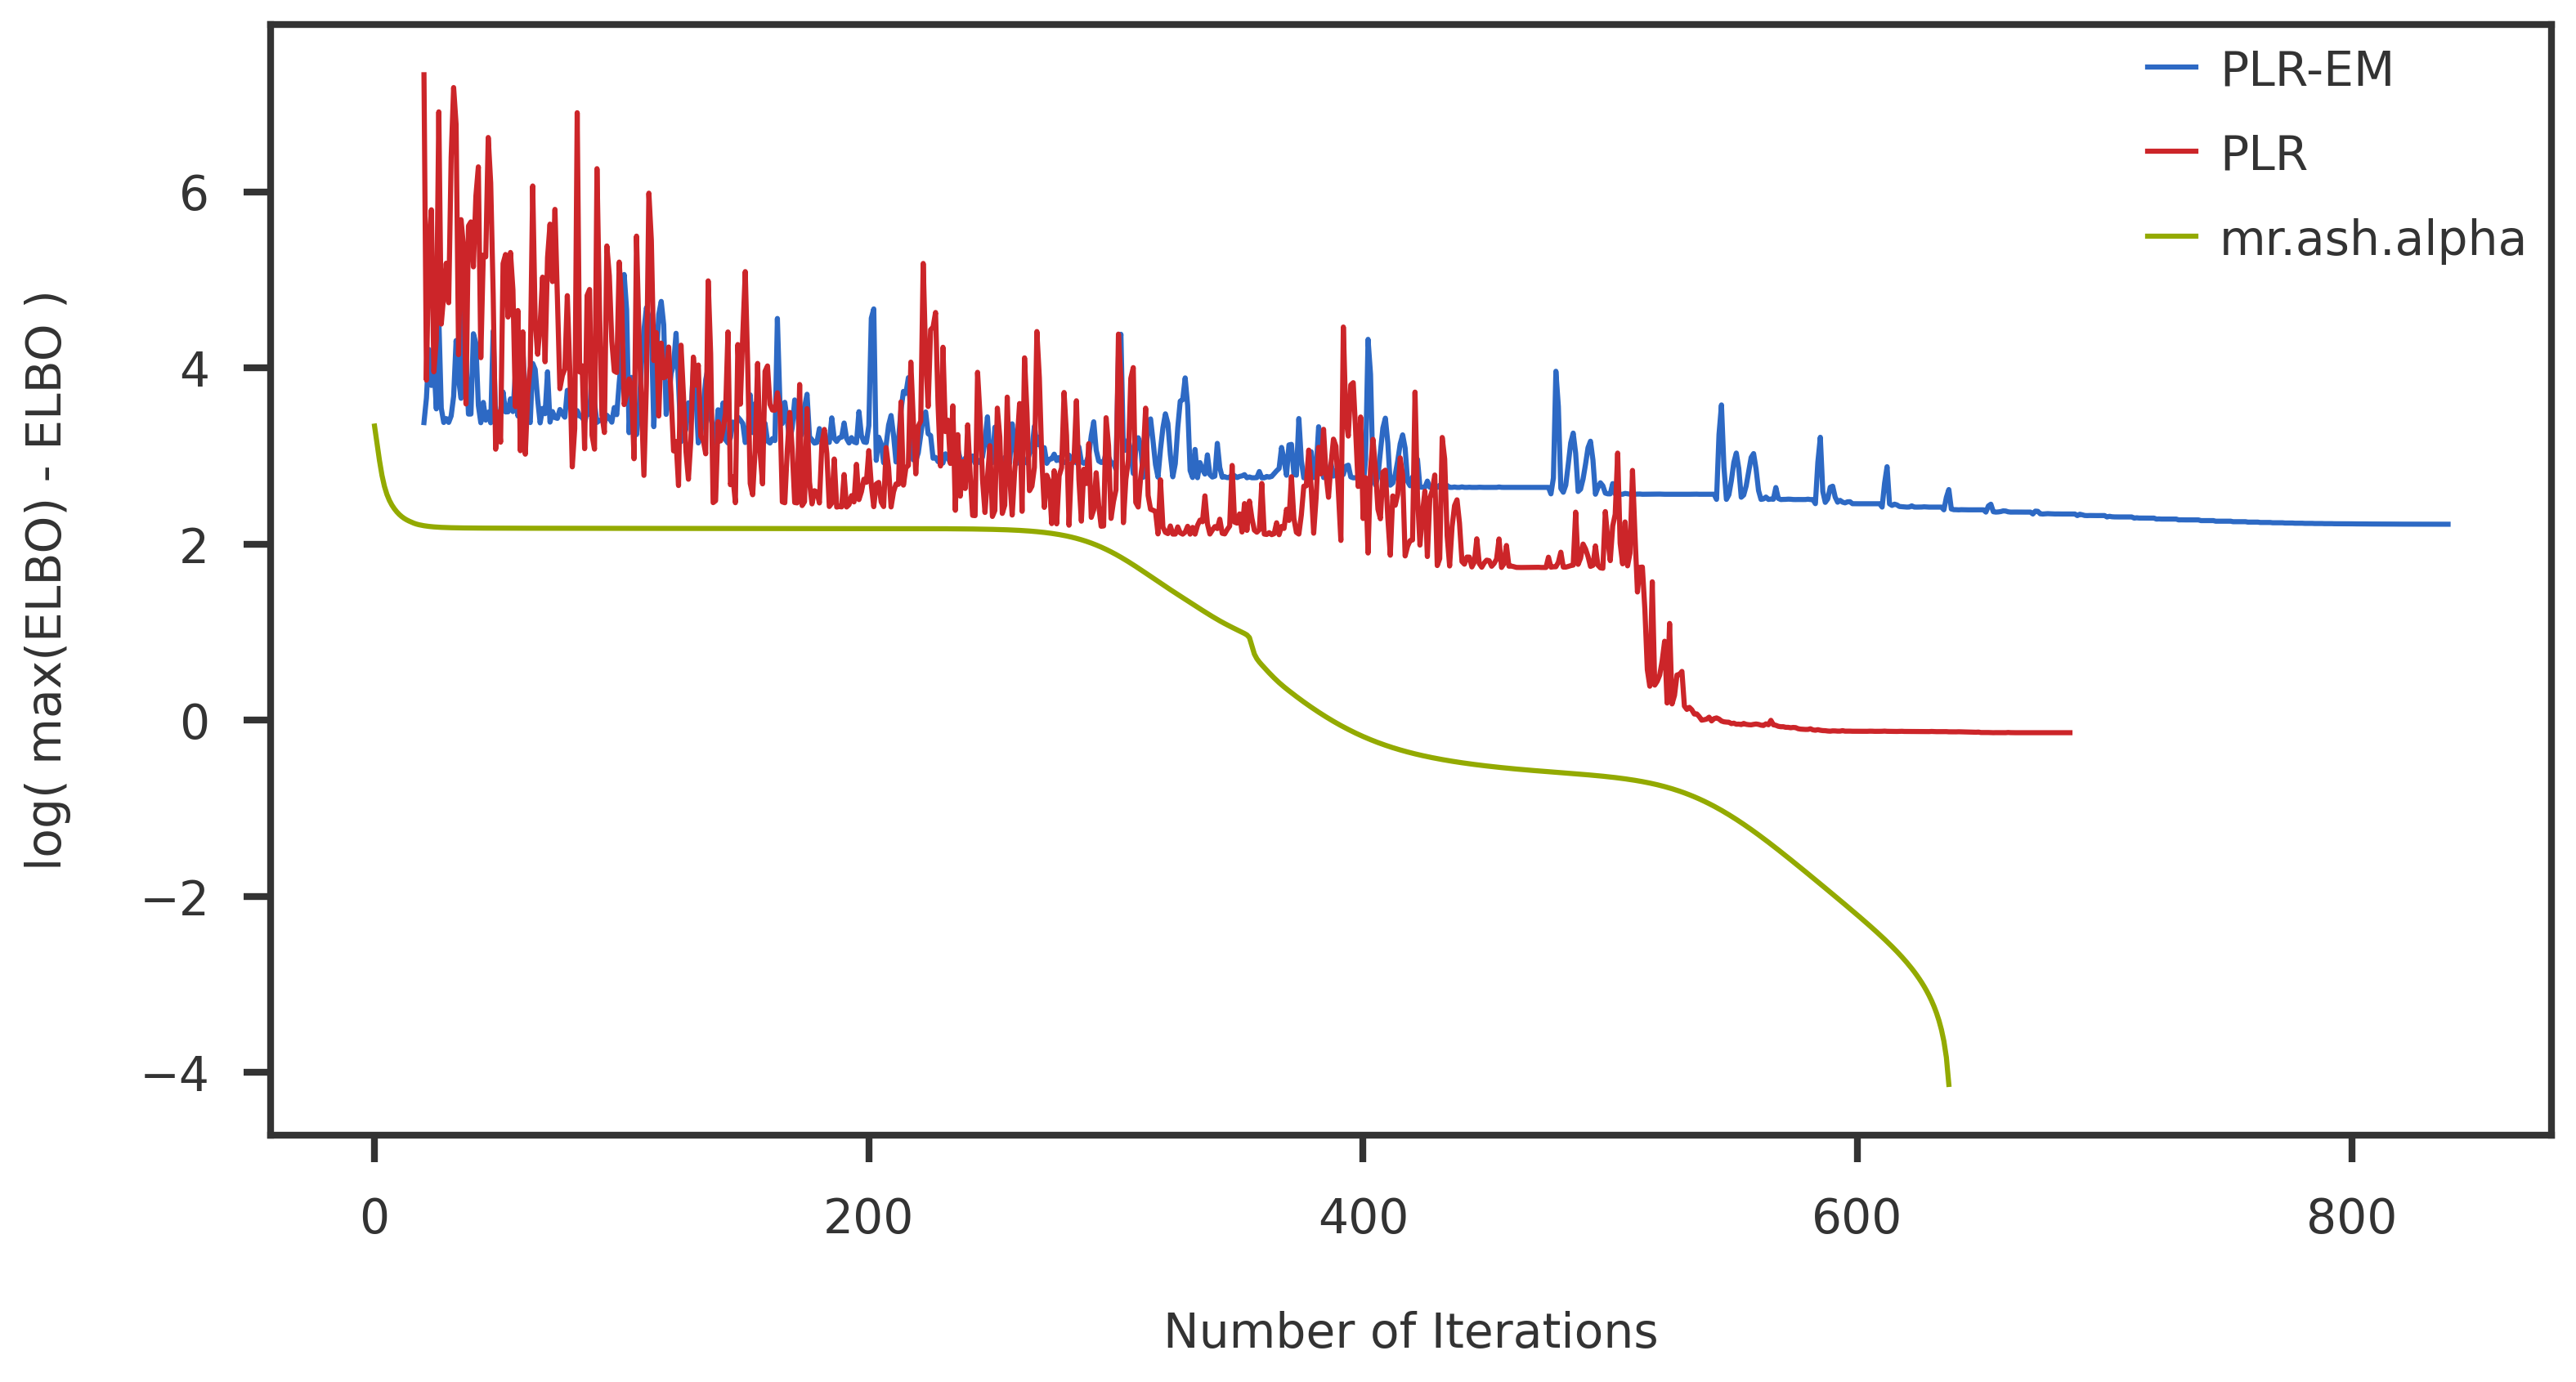

In [5]:
#collapse-hide

n = 200
p = 2000
p_causal = 20
pve = 0.7
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = 0.5, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

'''
PLR
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 1)

'''
PLR-EM
'''
plr_eb = ebfit(X, y, sk, wk, binit = None, s2init = 1, maxiter = 200, qb_maxiter = 100)

'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = np.zeros(p), winit = wk, s2init = 1)

'''
Plot
'''
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'PLR')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'PLR-EM')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')

kinit   = [20, 20, 0]
objs    = [plr_eb.elbo_path, plr_lbfgs.elbo_path, mrash_r.obj_path]
methods = ["PLR-EM", "PLR", "mr.ash.alpha"]
plot_convergence(objs, methods, kinit)

### Trendfiltering with basis k = 0

Mr.ASH terminated at iteration 303.


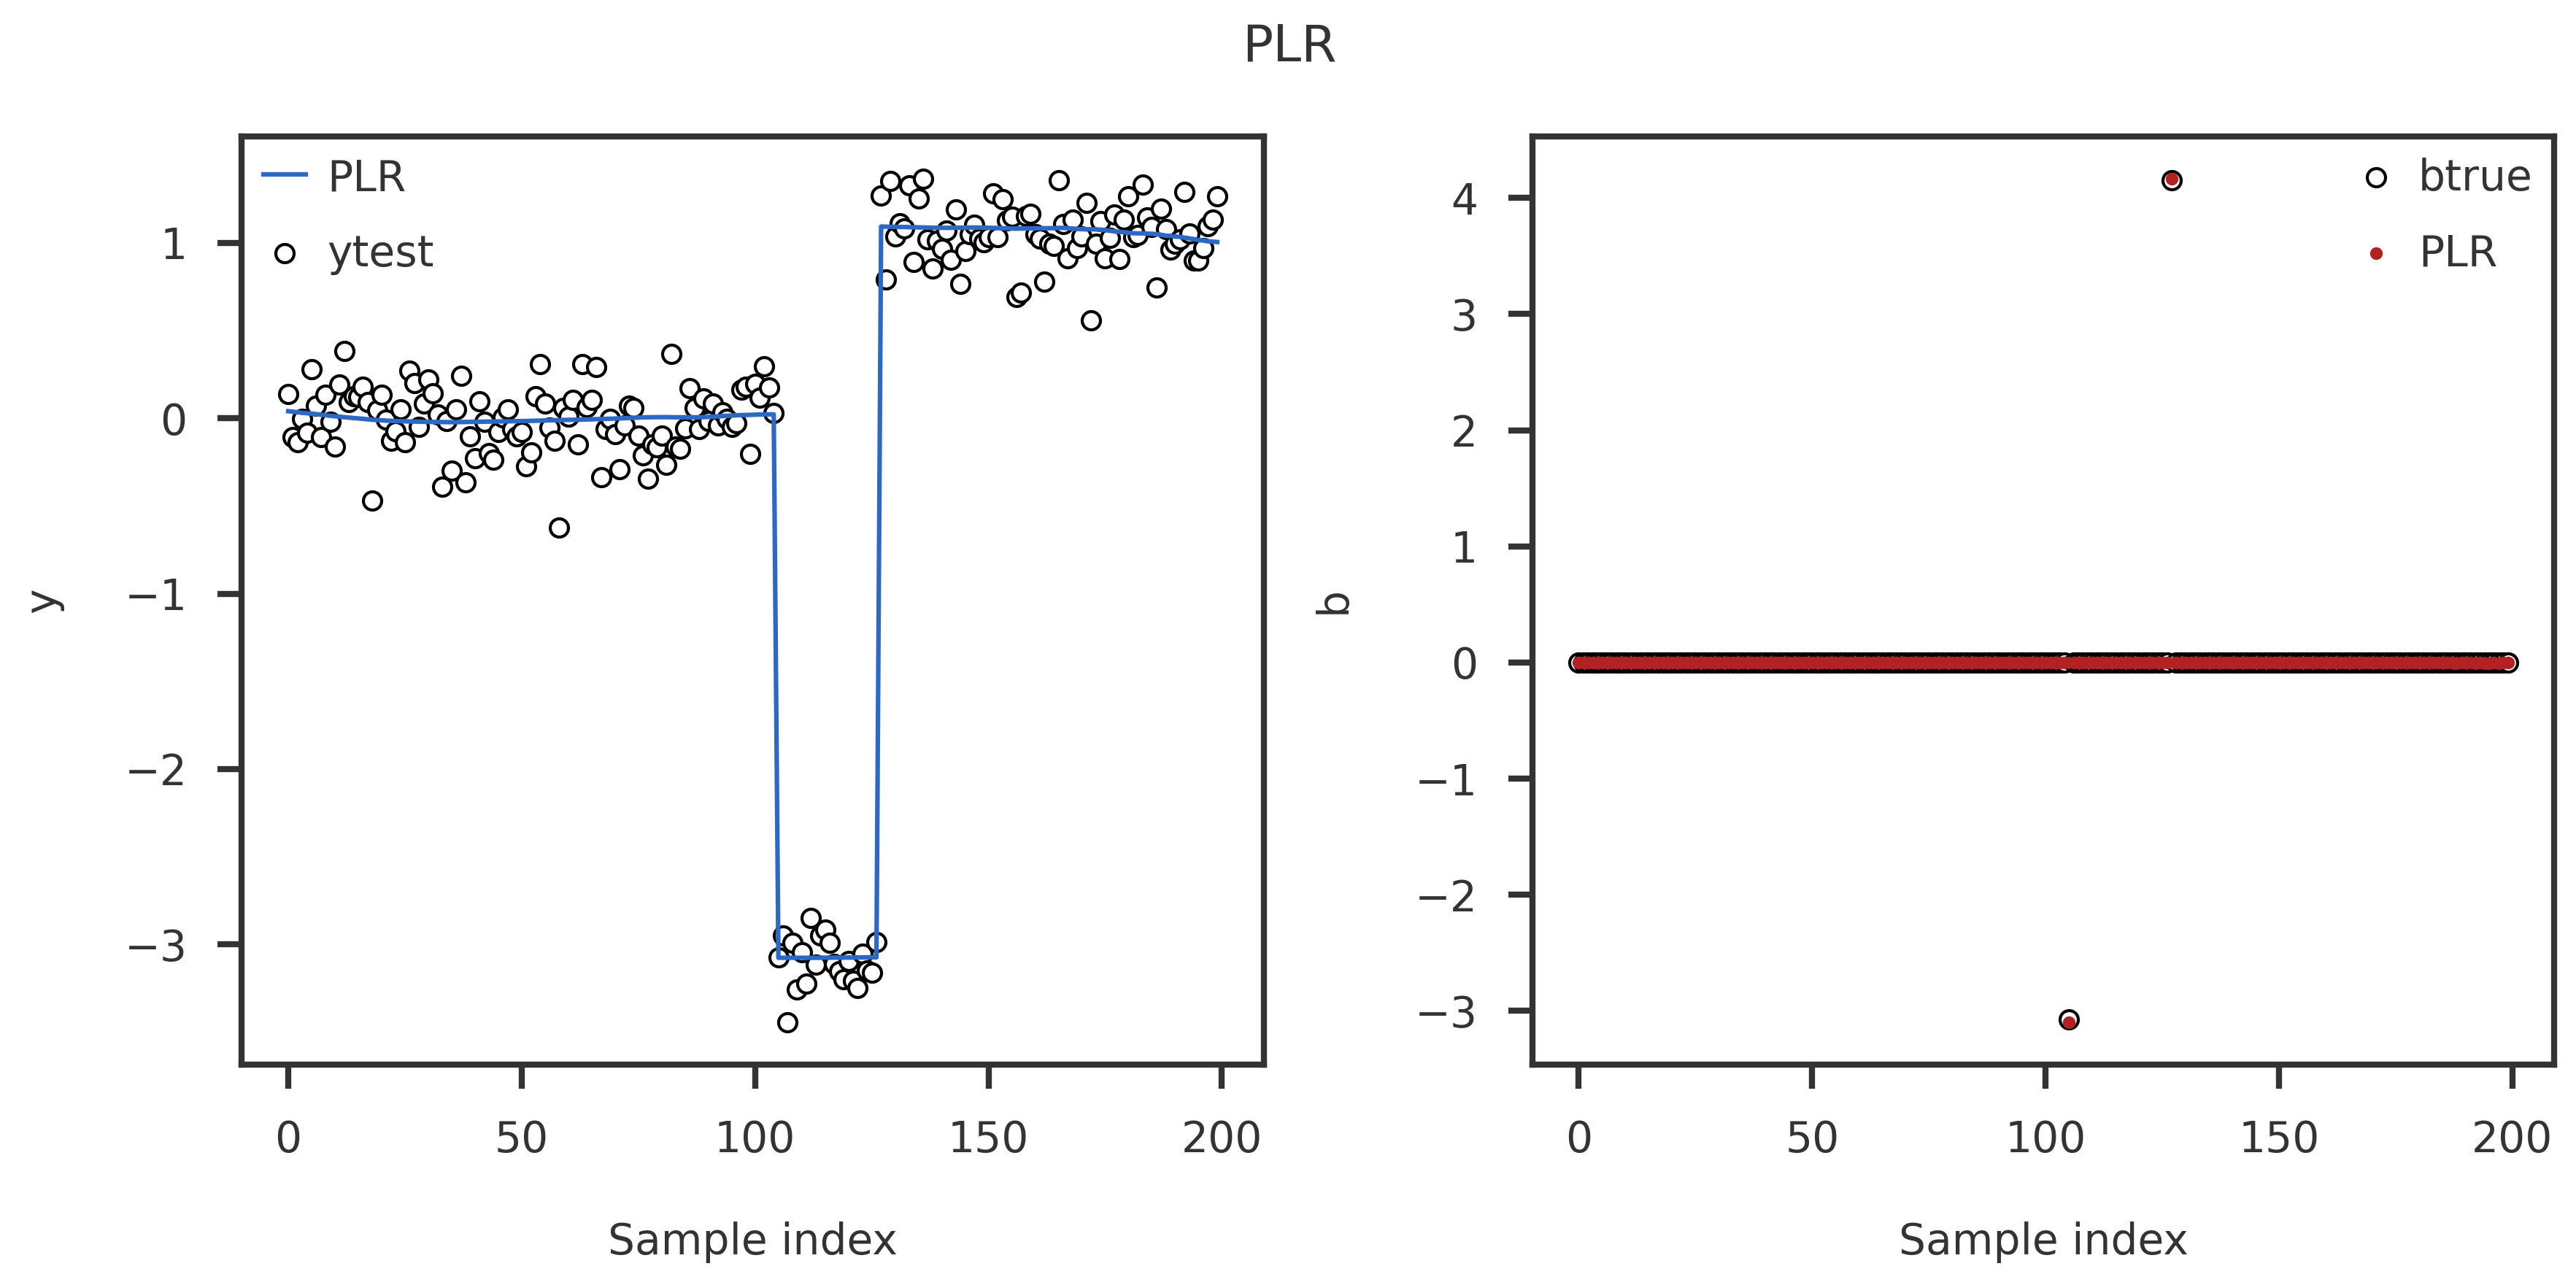

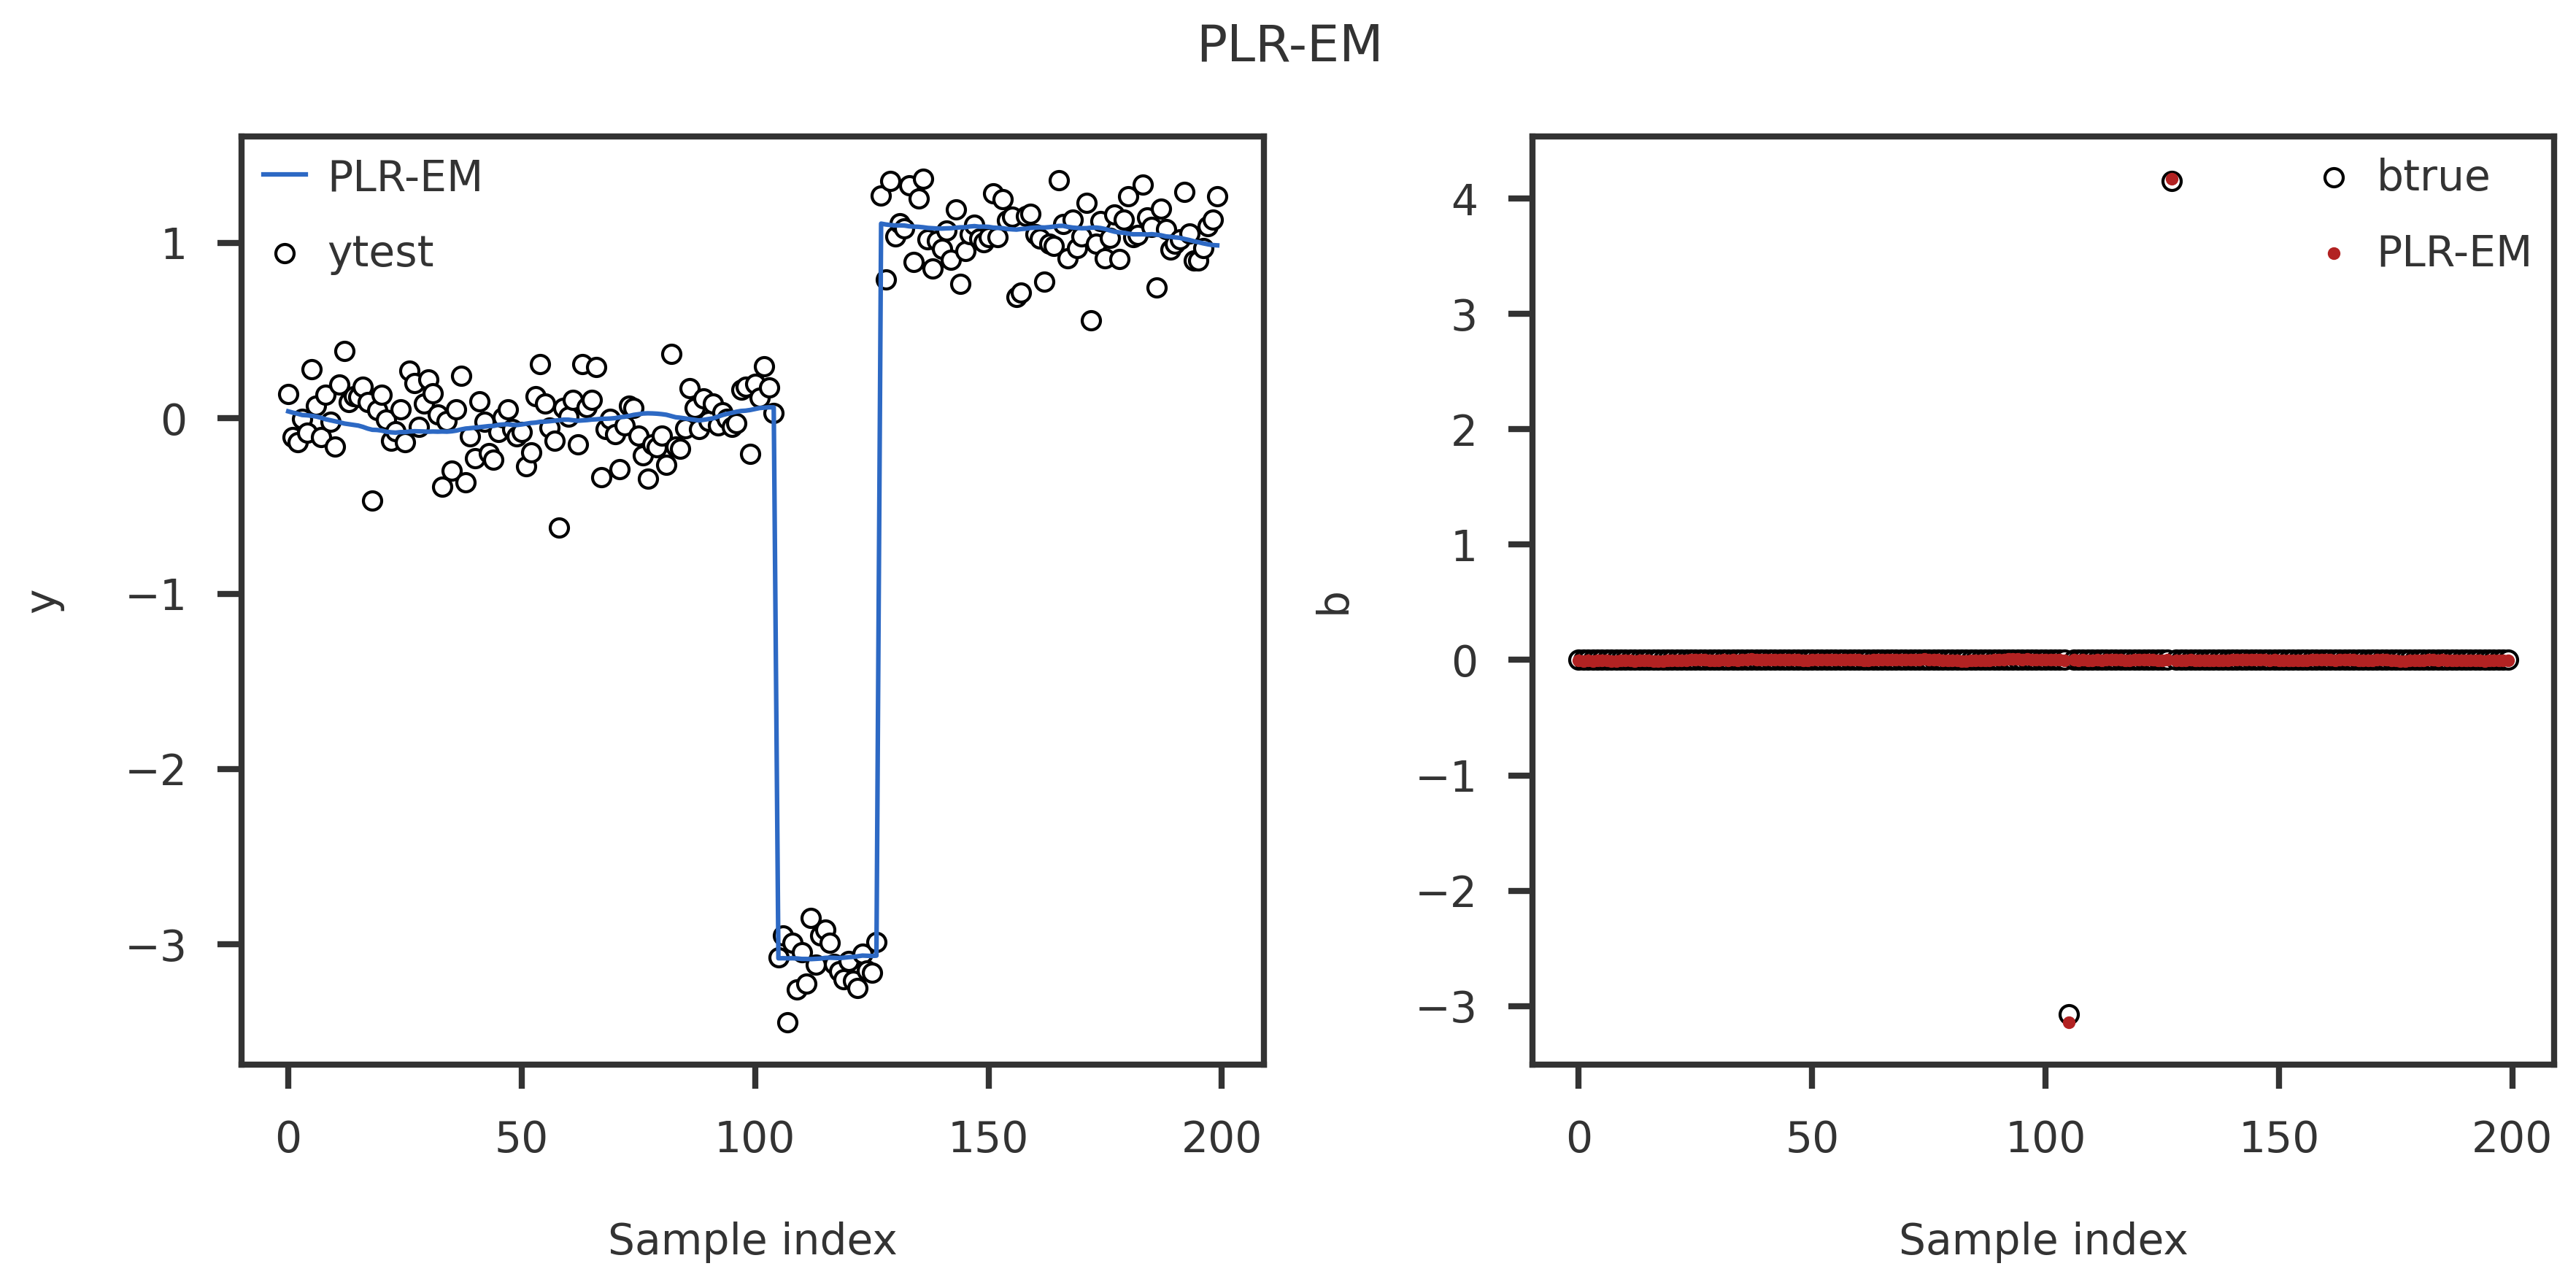

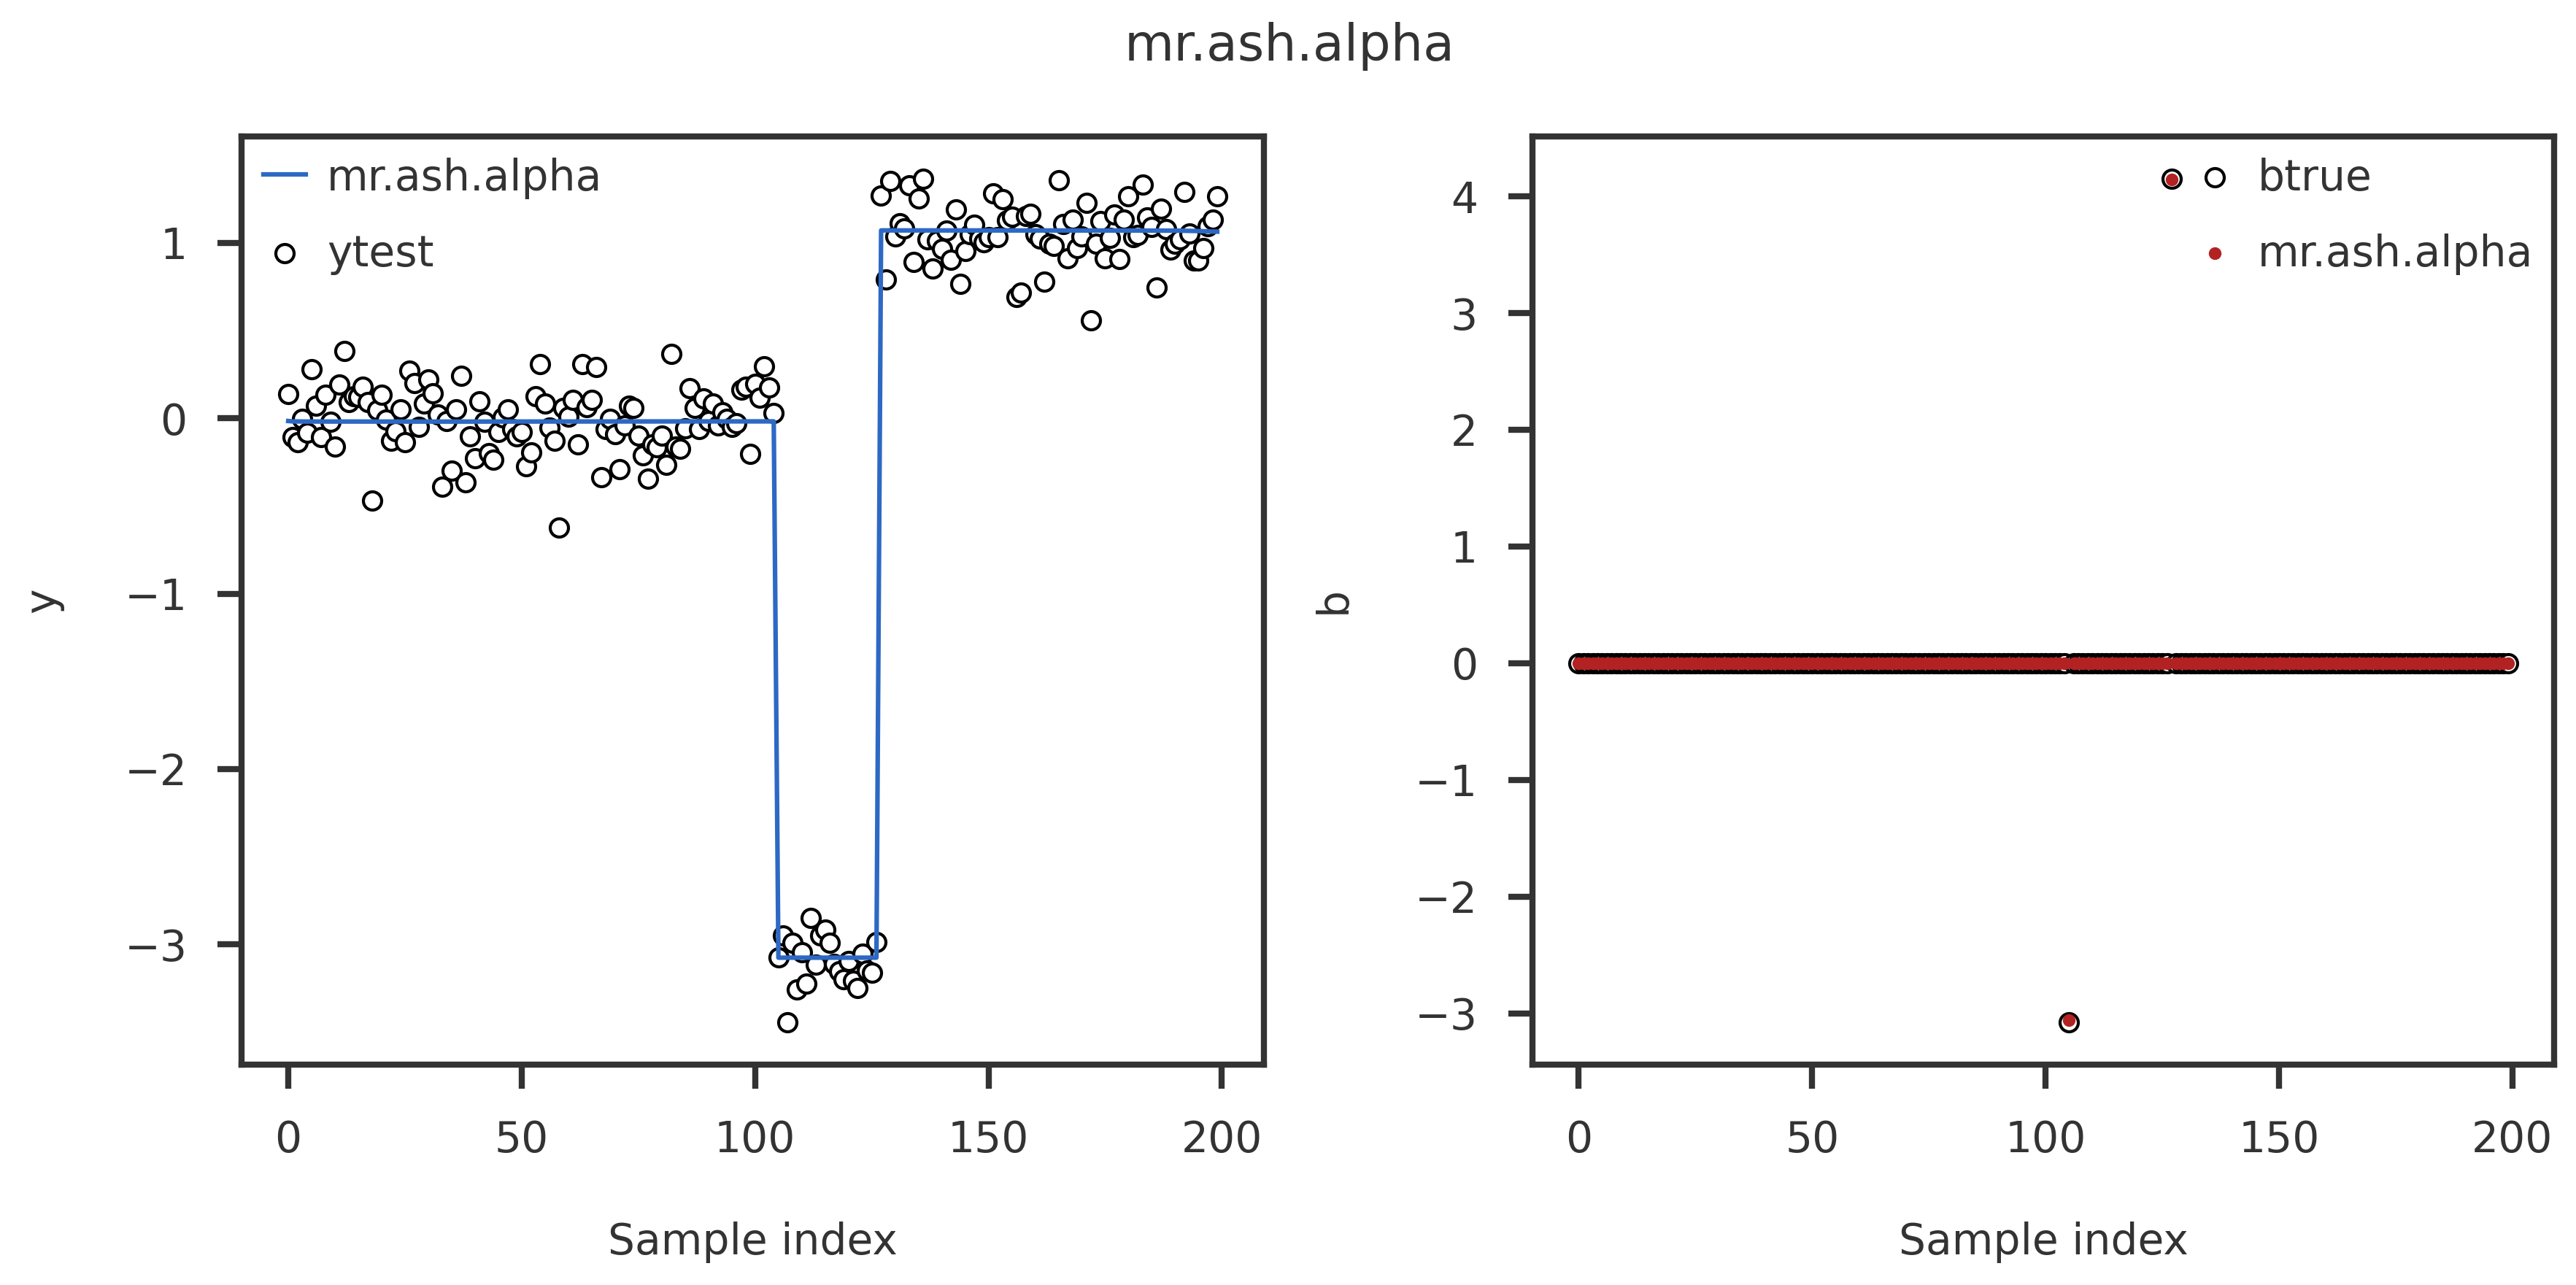

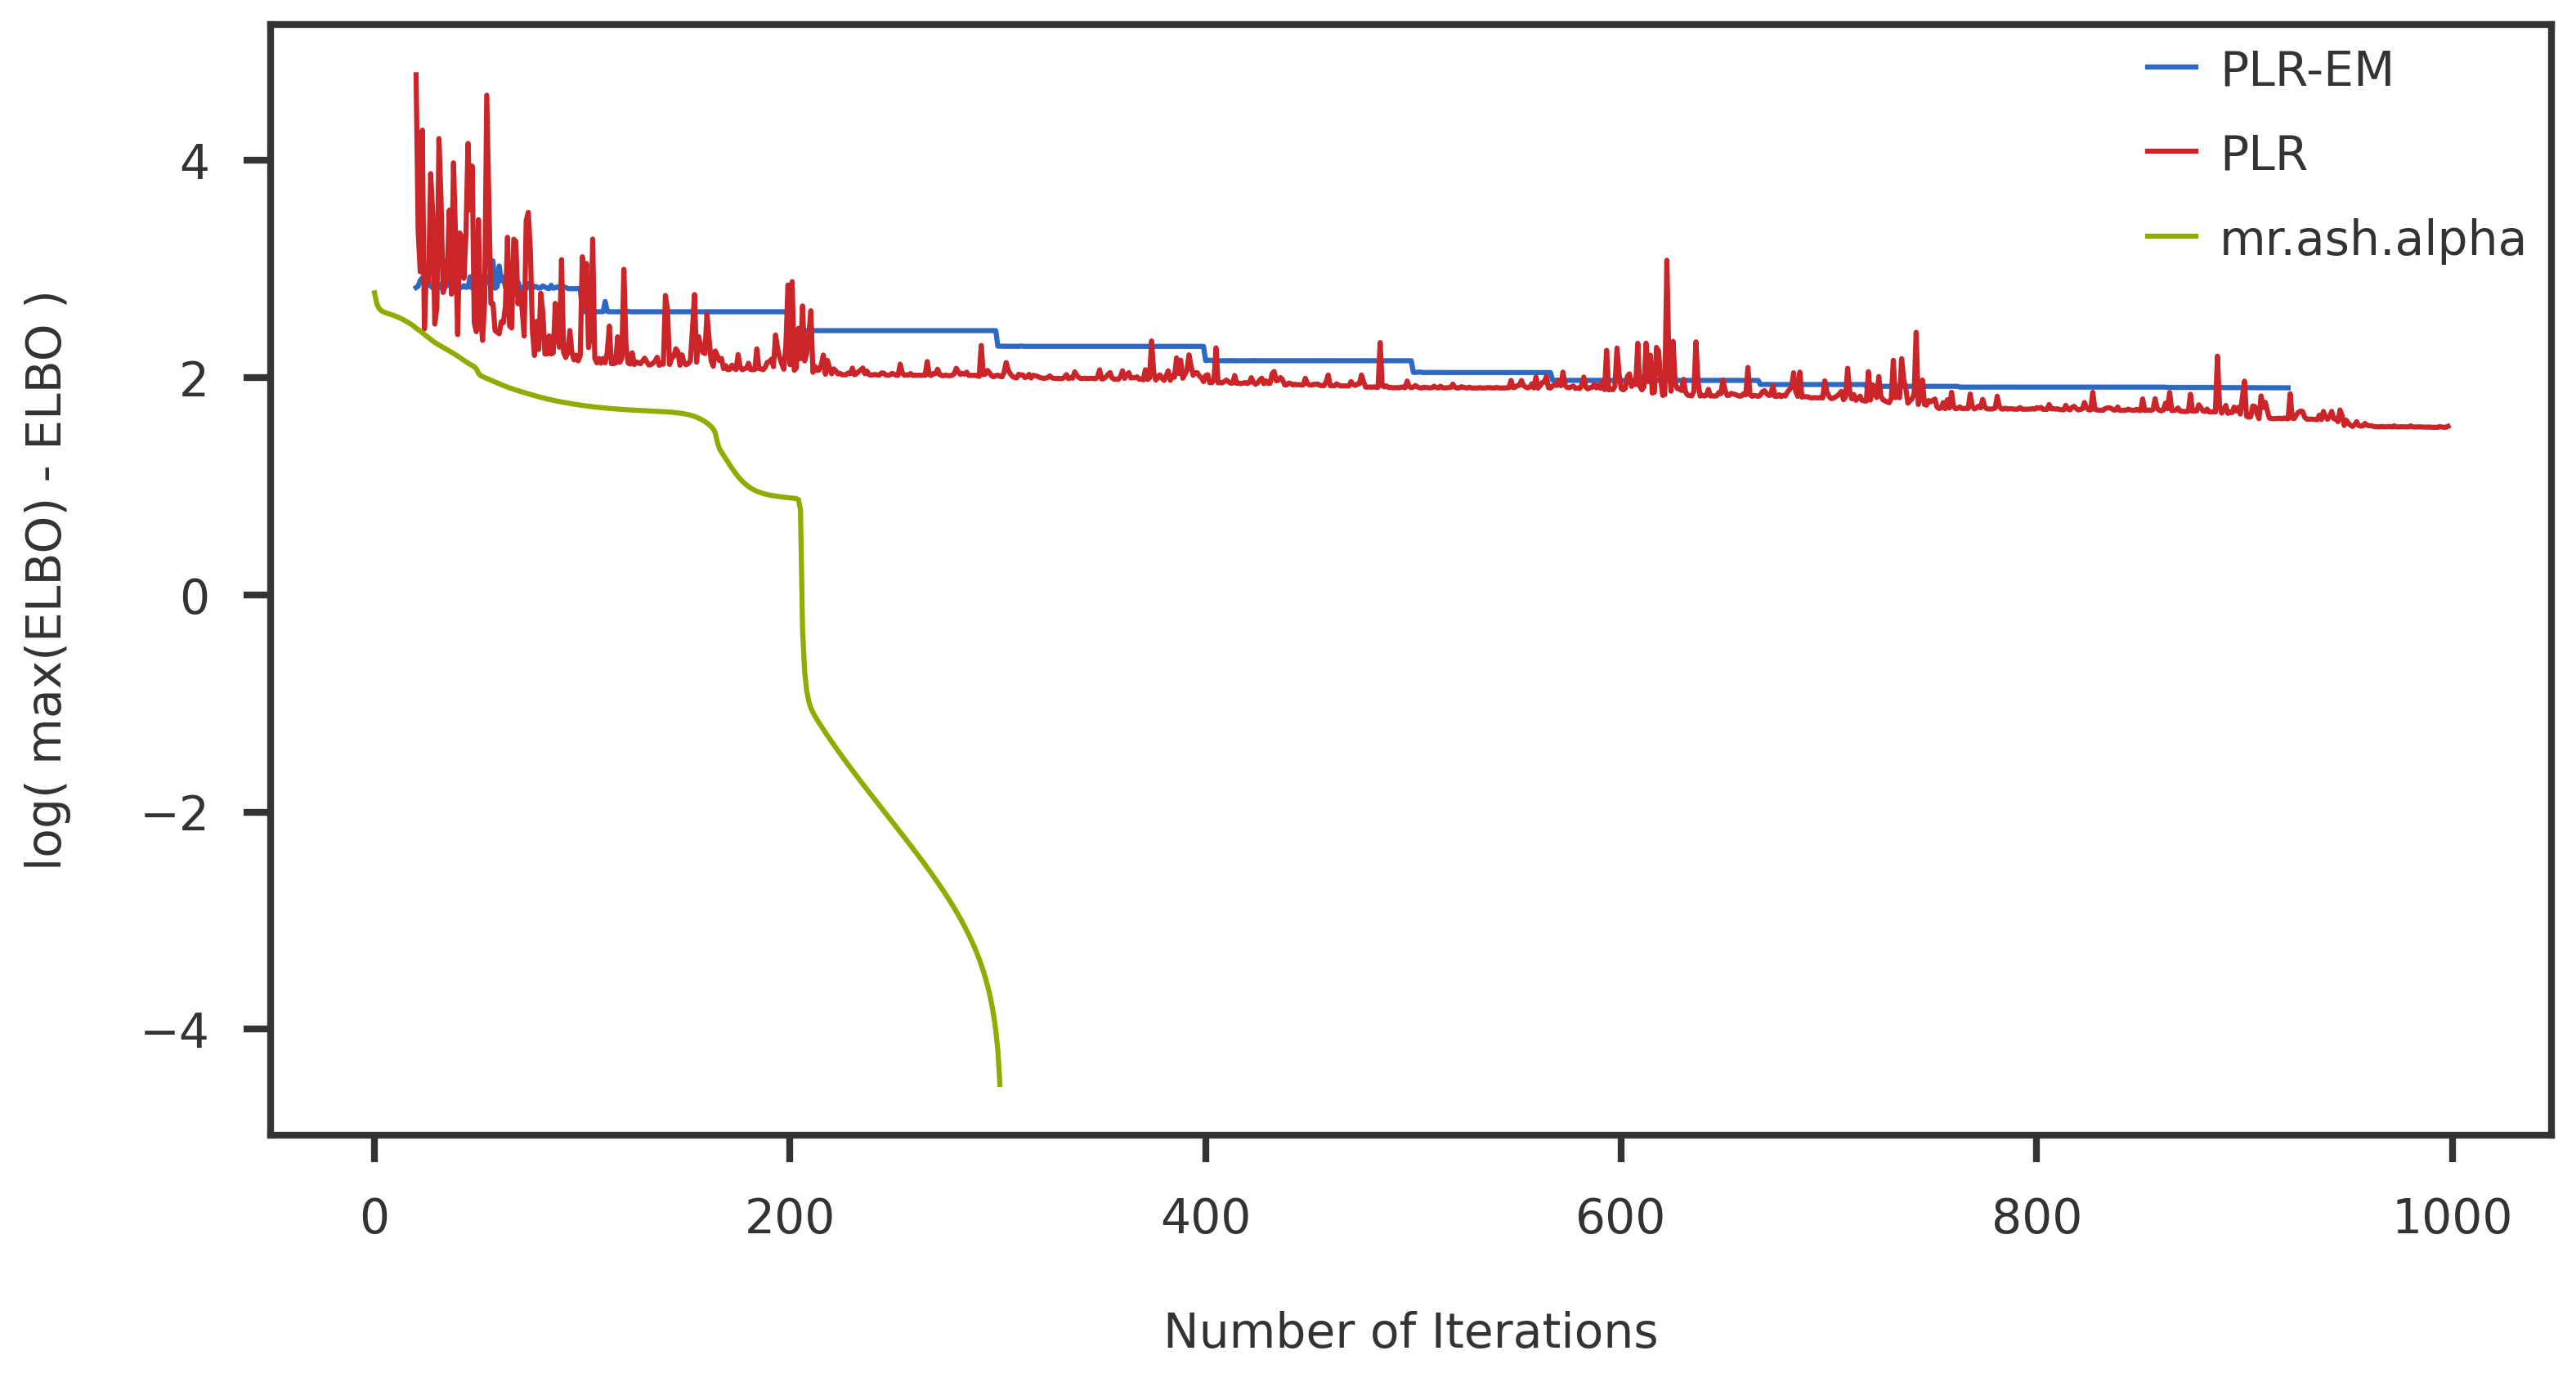

In [6]:
#collapse-hide

n = 200
p = 200
p_causal = 2
snr = 20
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                    k = 0, signal = 'gamma', seed = 100)
wk, sk = initialize_ash_prior(k, scale = 10)

'''
PLR
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 1)

'''
PLR-EM
'''
plr_eb = ebfit(X, y, sk, wk, binit = None, s2init = 1, maxiter = 200, qb_maxiter = 100)

'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = np.zeros(p), winit = wk, s2init = 1)

#collapse-hide
'''
Plot
'''
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'PLR')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'PLR-EM')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')

kinit   = [20, 20, 0]
objs    = [plr_eb.elbo_path, plr_lbfgs.elbo_path, mrash_r.obj_path]
methods = ["PLR-EM", "PLR", "mr.ash.alpha"]
plot_convergence(objs, methods, kinit)

### Trendfiltering with less sparsity (p_causal = 20)

Mr.ASH terminated at iteration 1010.


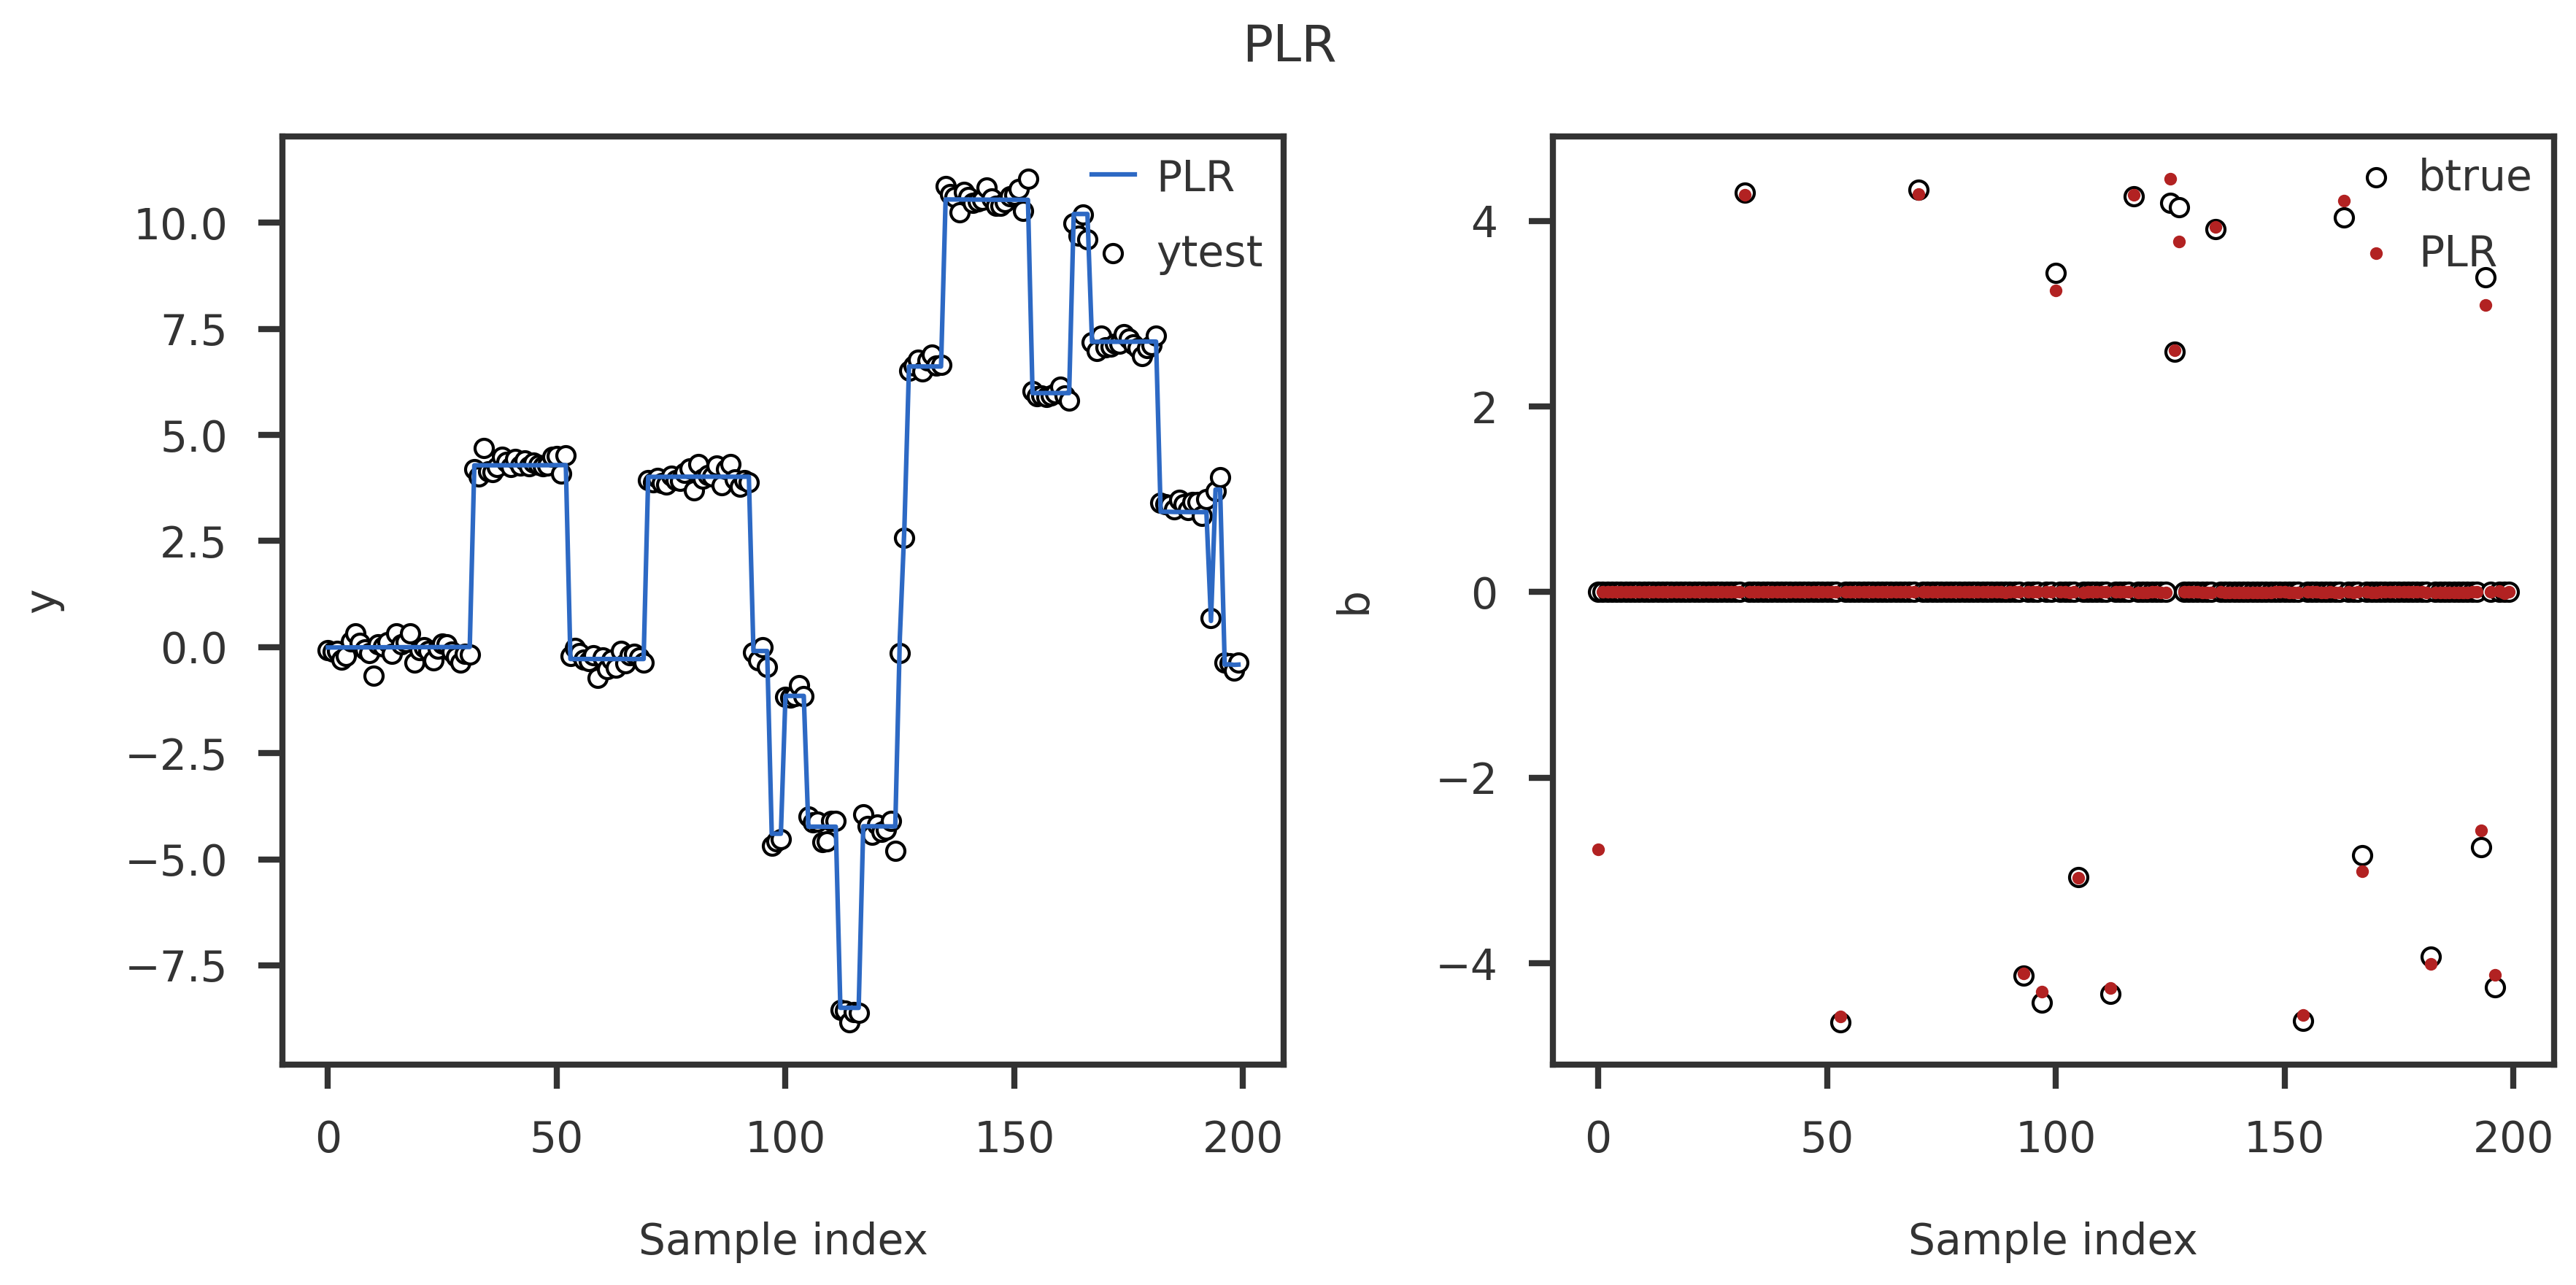

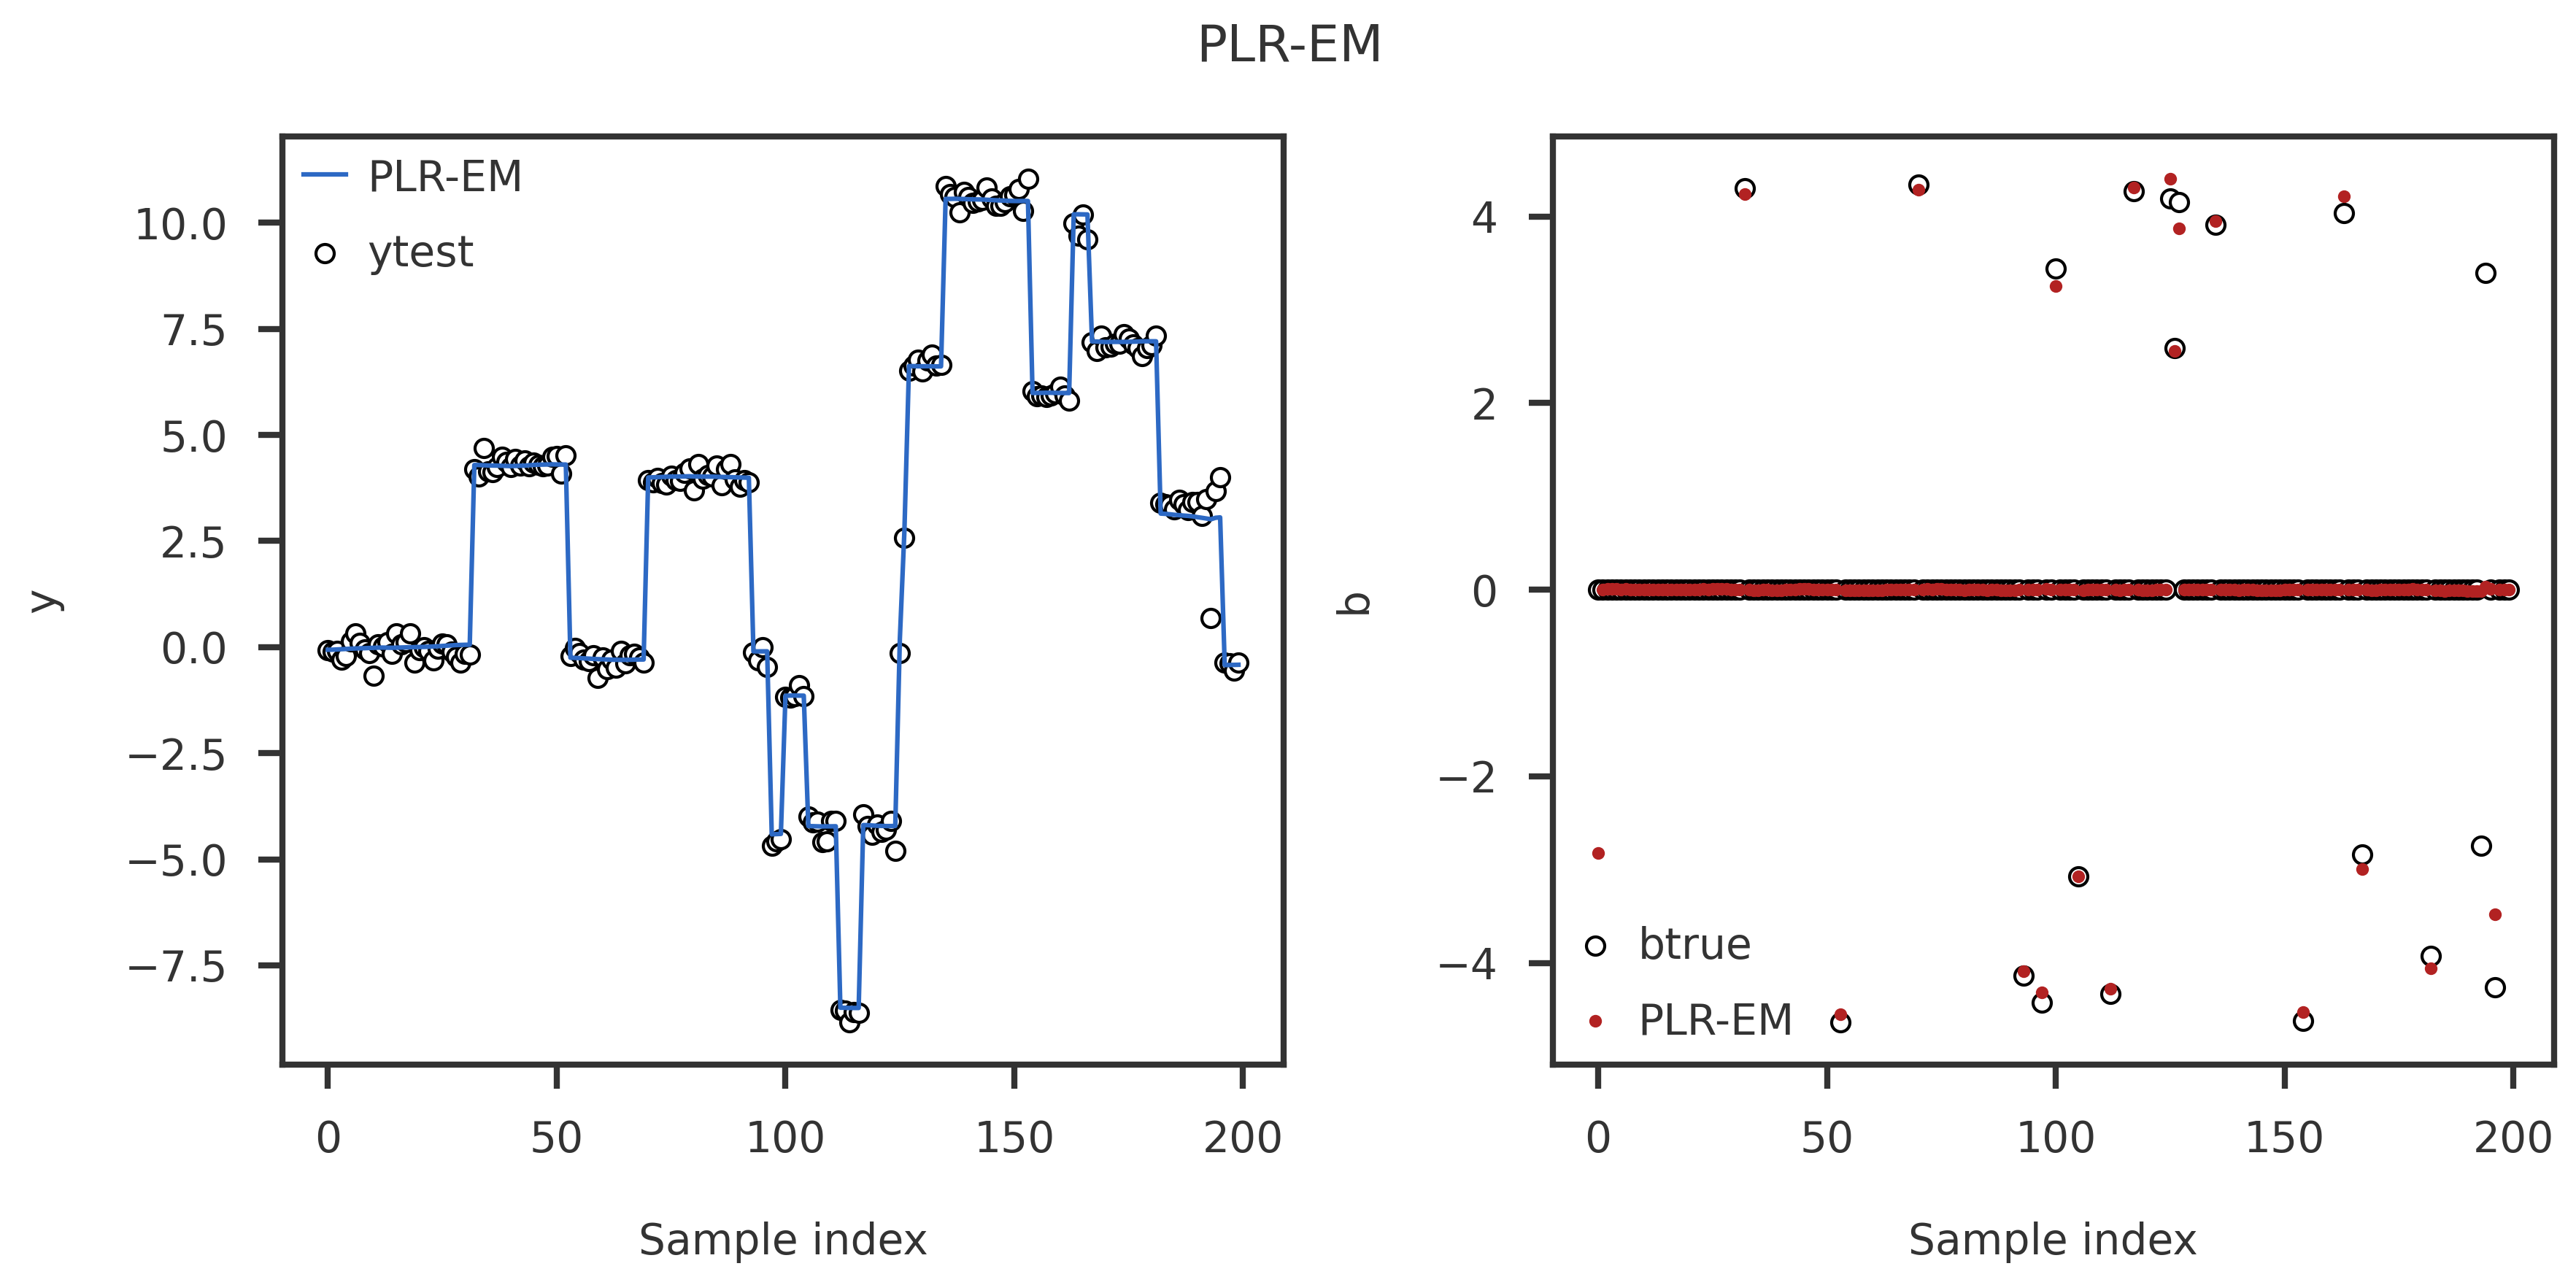

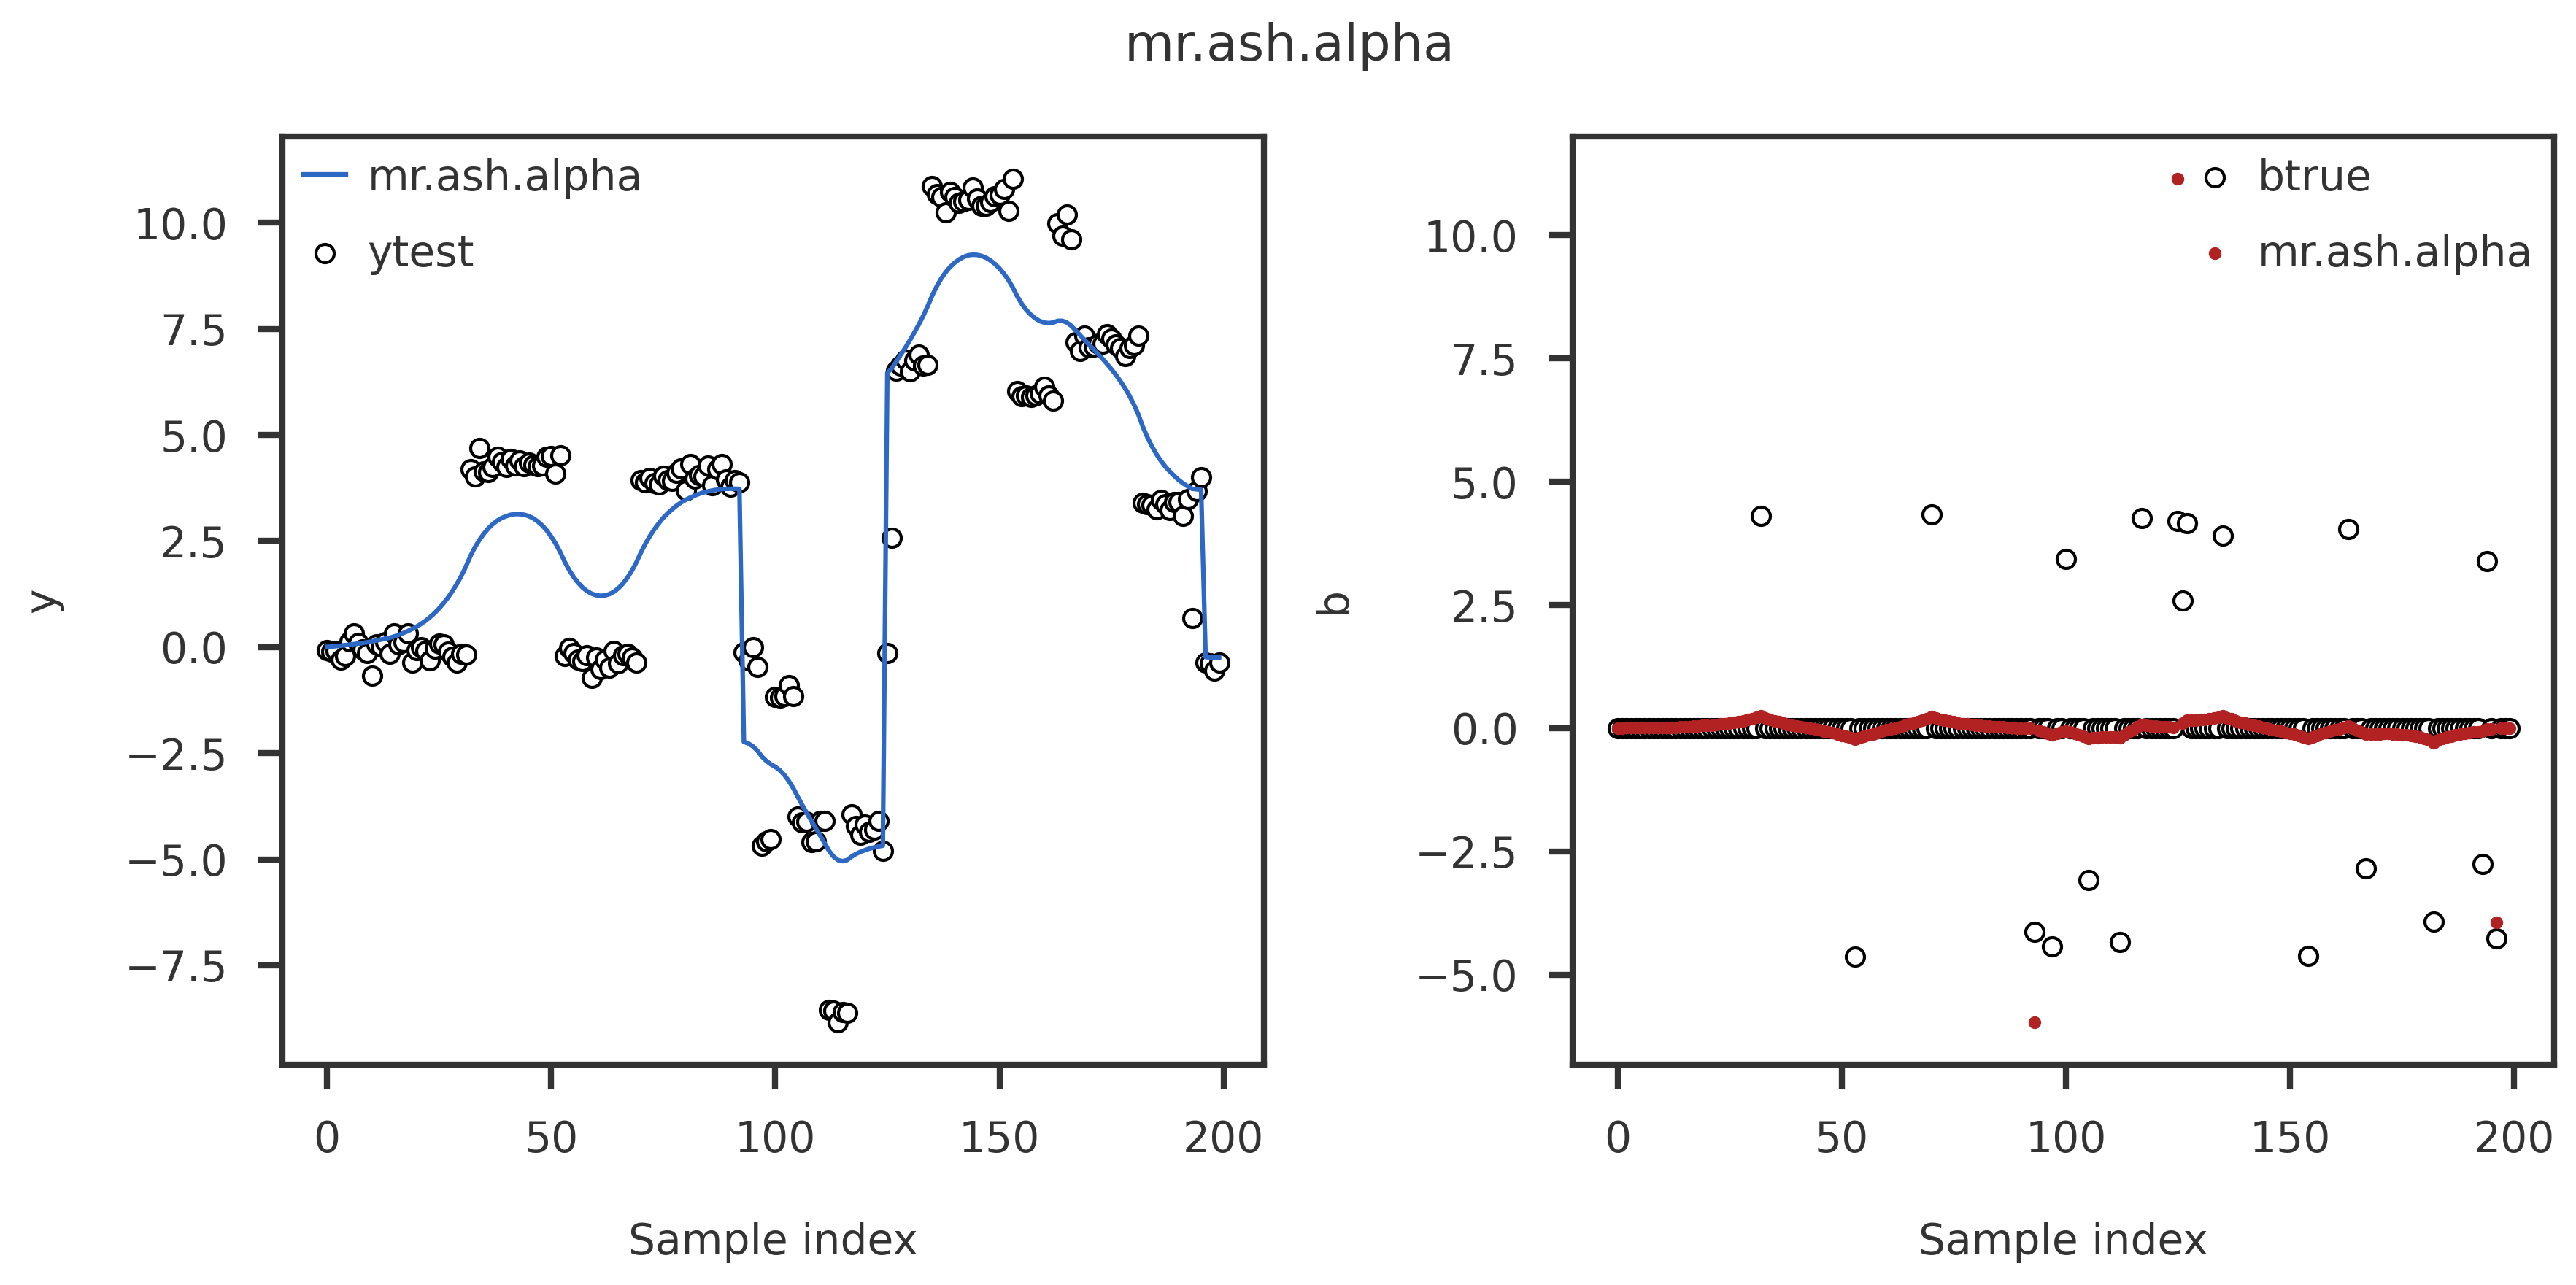

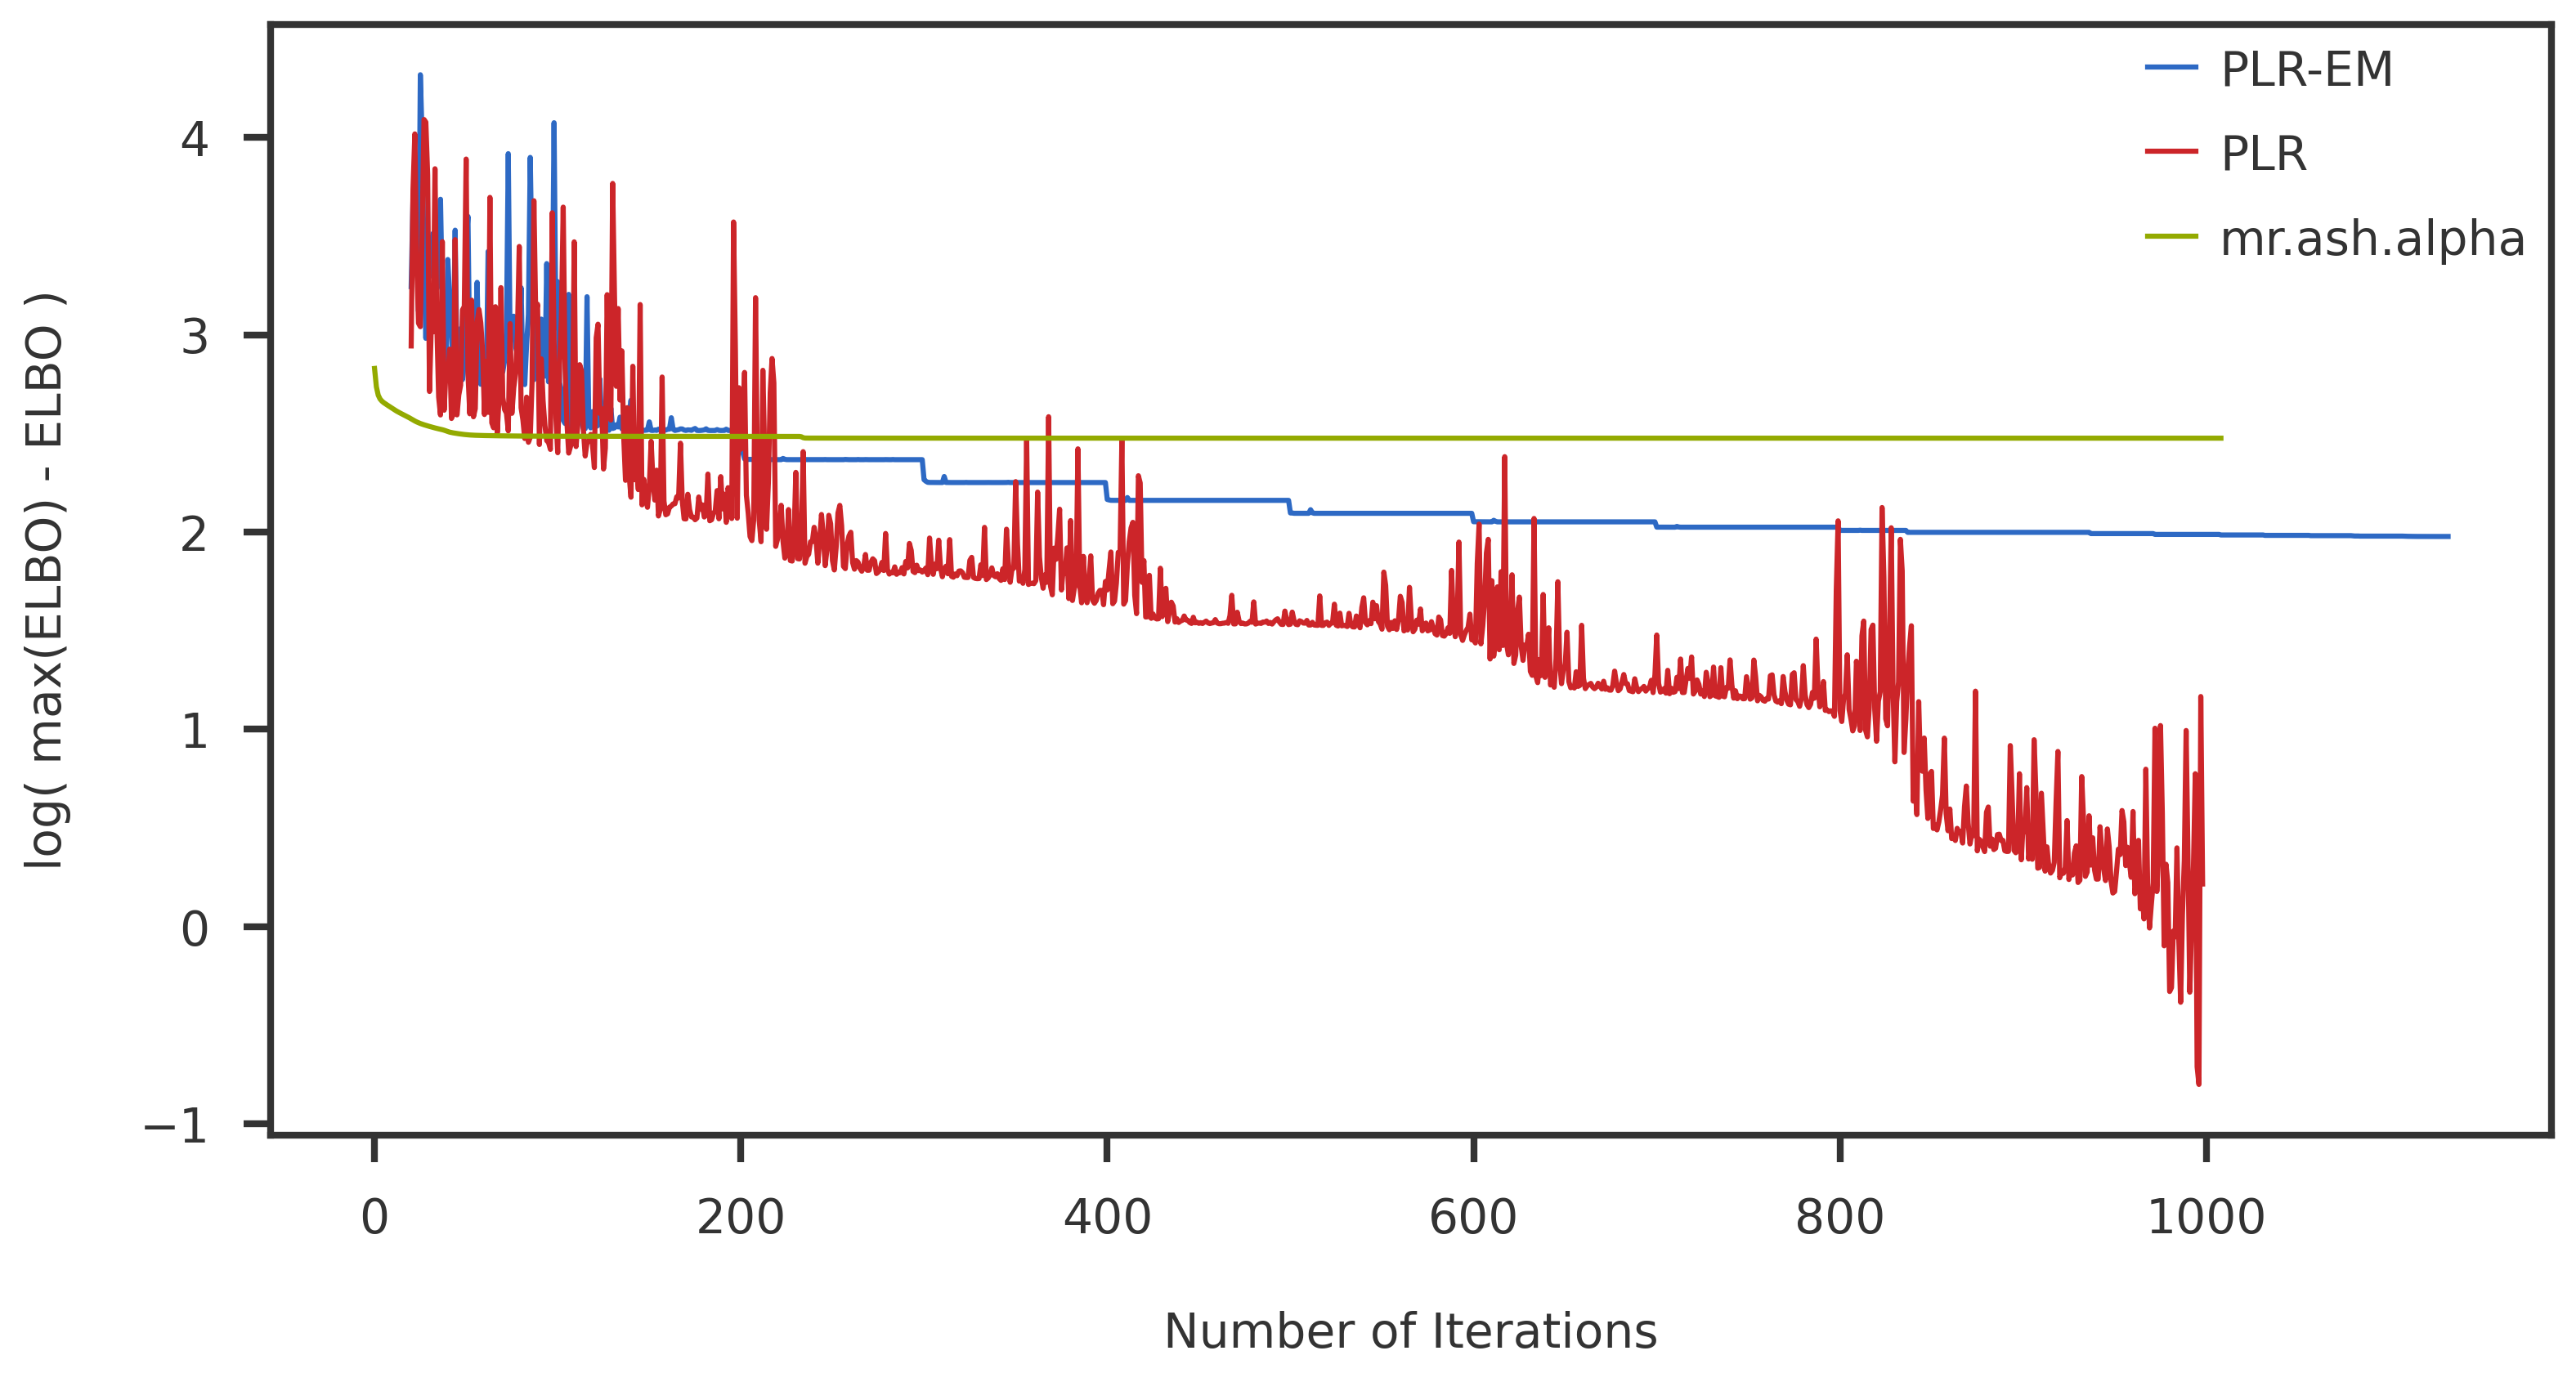

In [7]:
#collapse-hide

n = 200
p = 200
p_causal = 20
snr = 20
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                    k = 0, signal = 'gamma', seed = 100)
wk, sk = initialize_ash_prior(k, scale = 10)

'''
PLR
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 1)

'''
PLR-EM
'''
plr_eb = ebfit(X, y, sk, wk, binit = None, s2init = 1, maxiter = 200, qb_maxiter = 100)

'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = np.zeros(p), winit = wk, s2init = 1)

'''
Plot
'''
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'PLR')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'PLR-EM')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')

kinit   = [20, 20, 0]
objs    = [plr_eb.elbo_path, plr_lbfgs.elbo_path, mrash_r.obj_path]
methods = ["PLR-EM", "PLR", "mr.ash.alpha"]
plot_convergence(objs, methods, kinit)

### Trendfiltering with basis k = 1

In [8]:
#collapse-hide

n = 200
p = 200
p_causal = 2
snr = 50
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.changepoint_predictors (n, p, p_causal, snr, 
                                                                    k = 1, signal = 'gamma', seed = 100)
wk, sk = initialize_ash_prior(k, scale = 20)

Mr.ASH terminated at iteration 346.


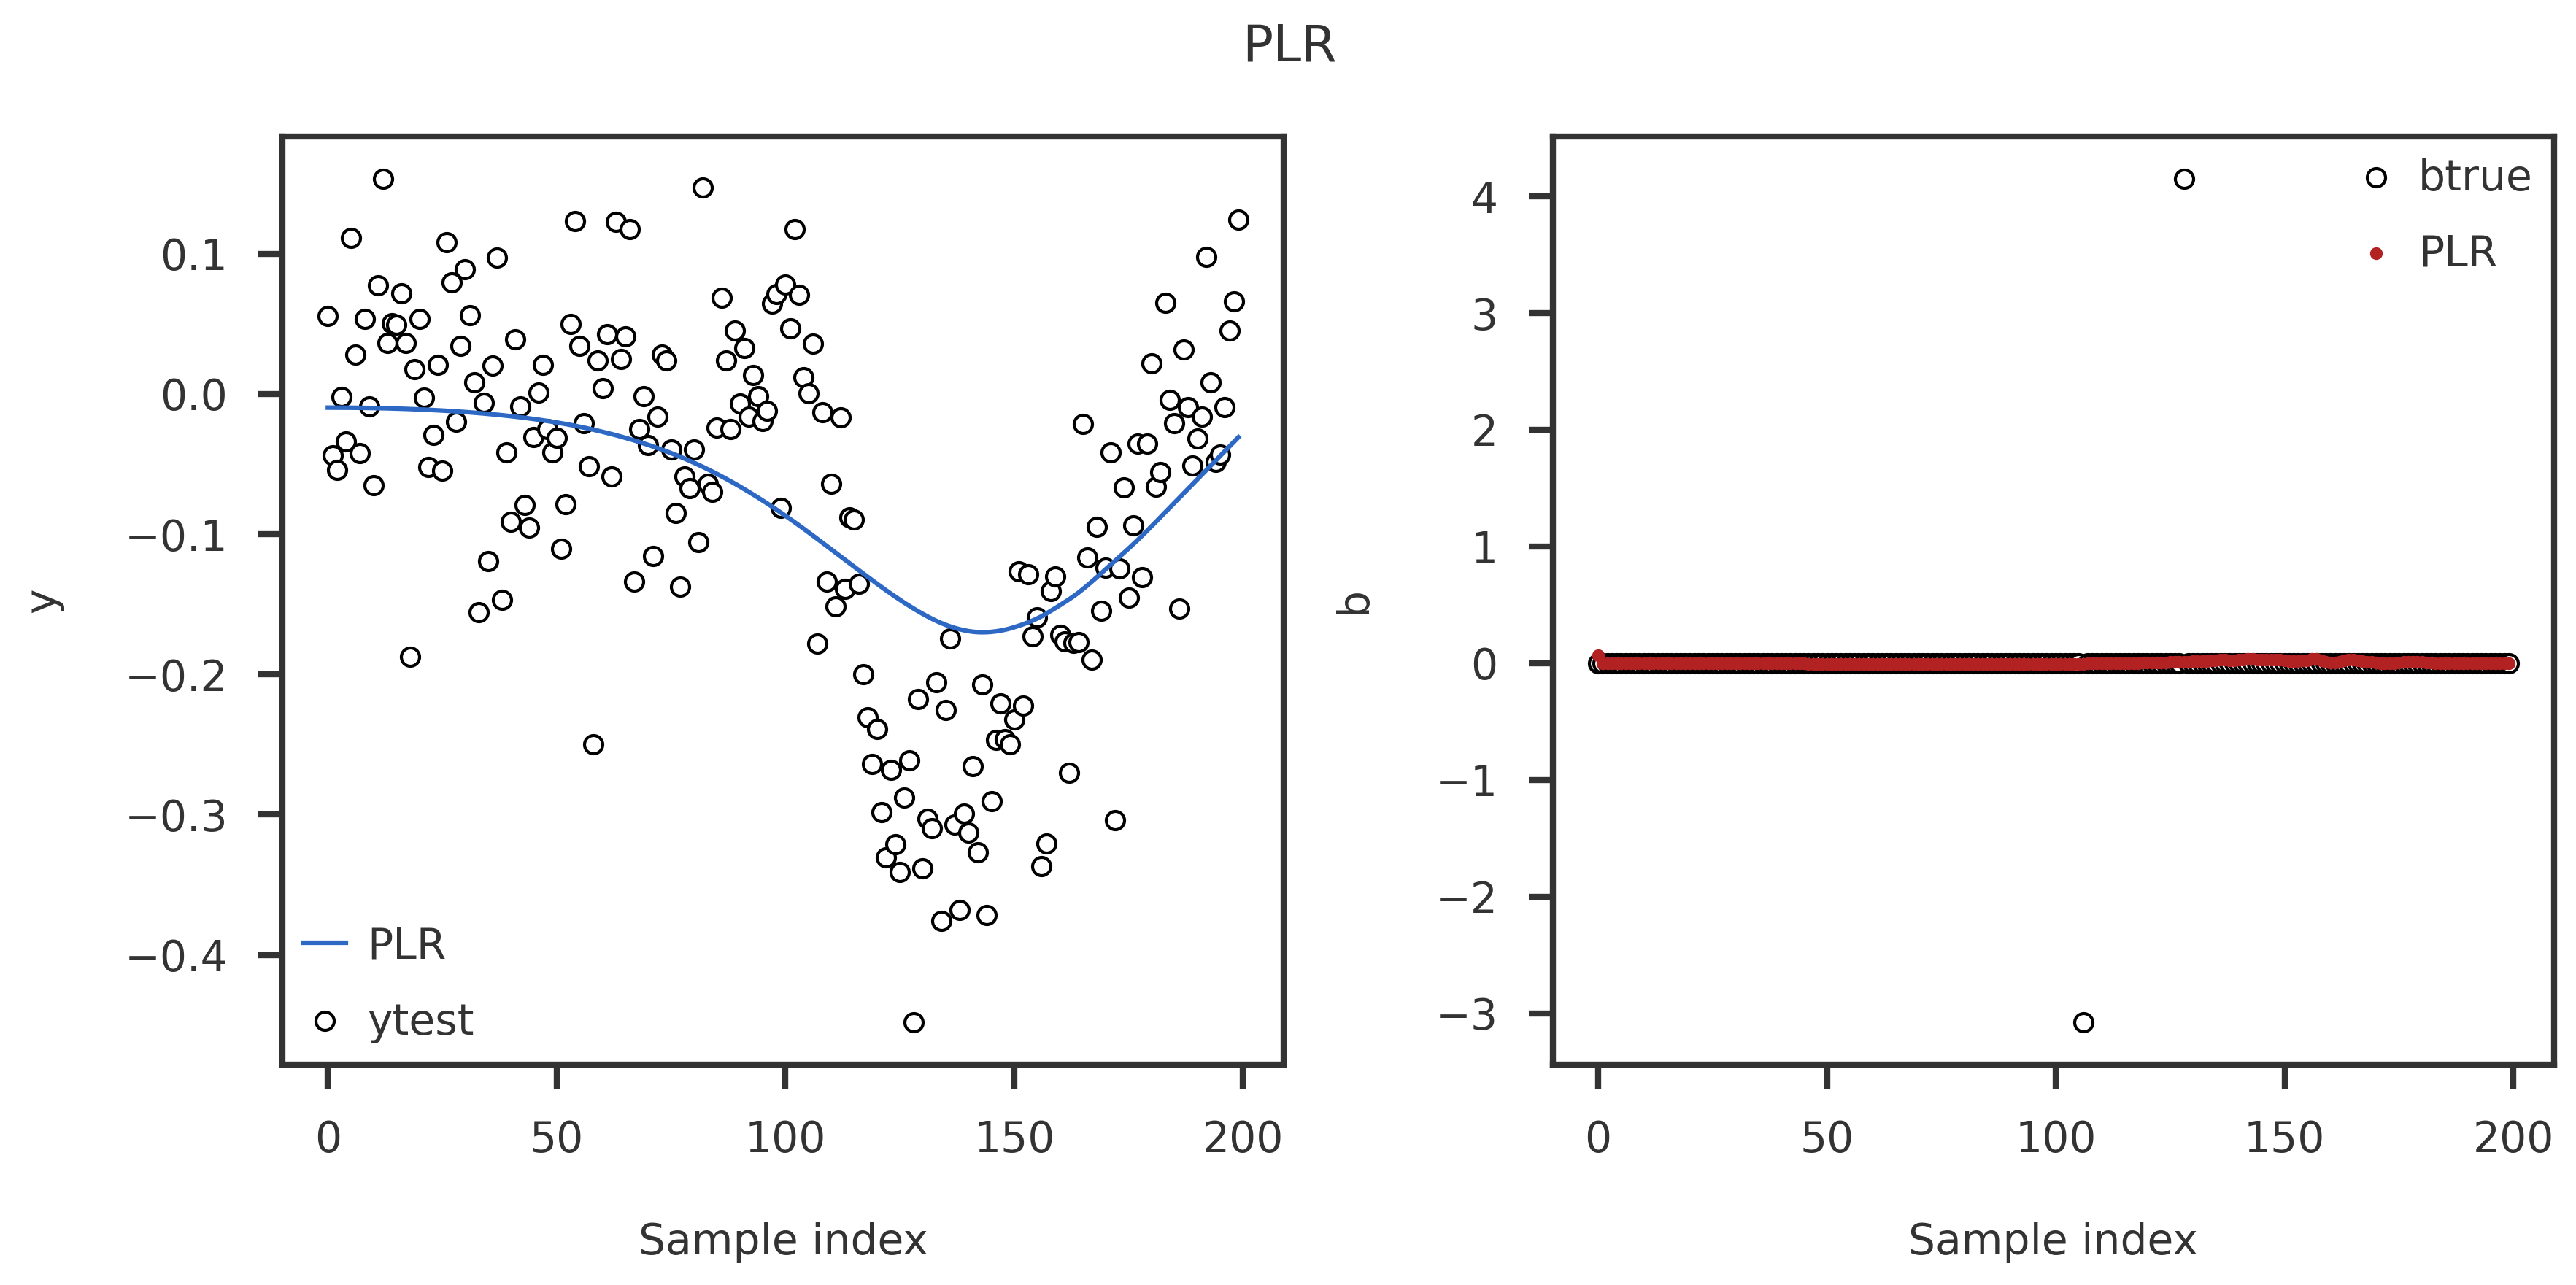

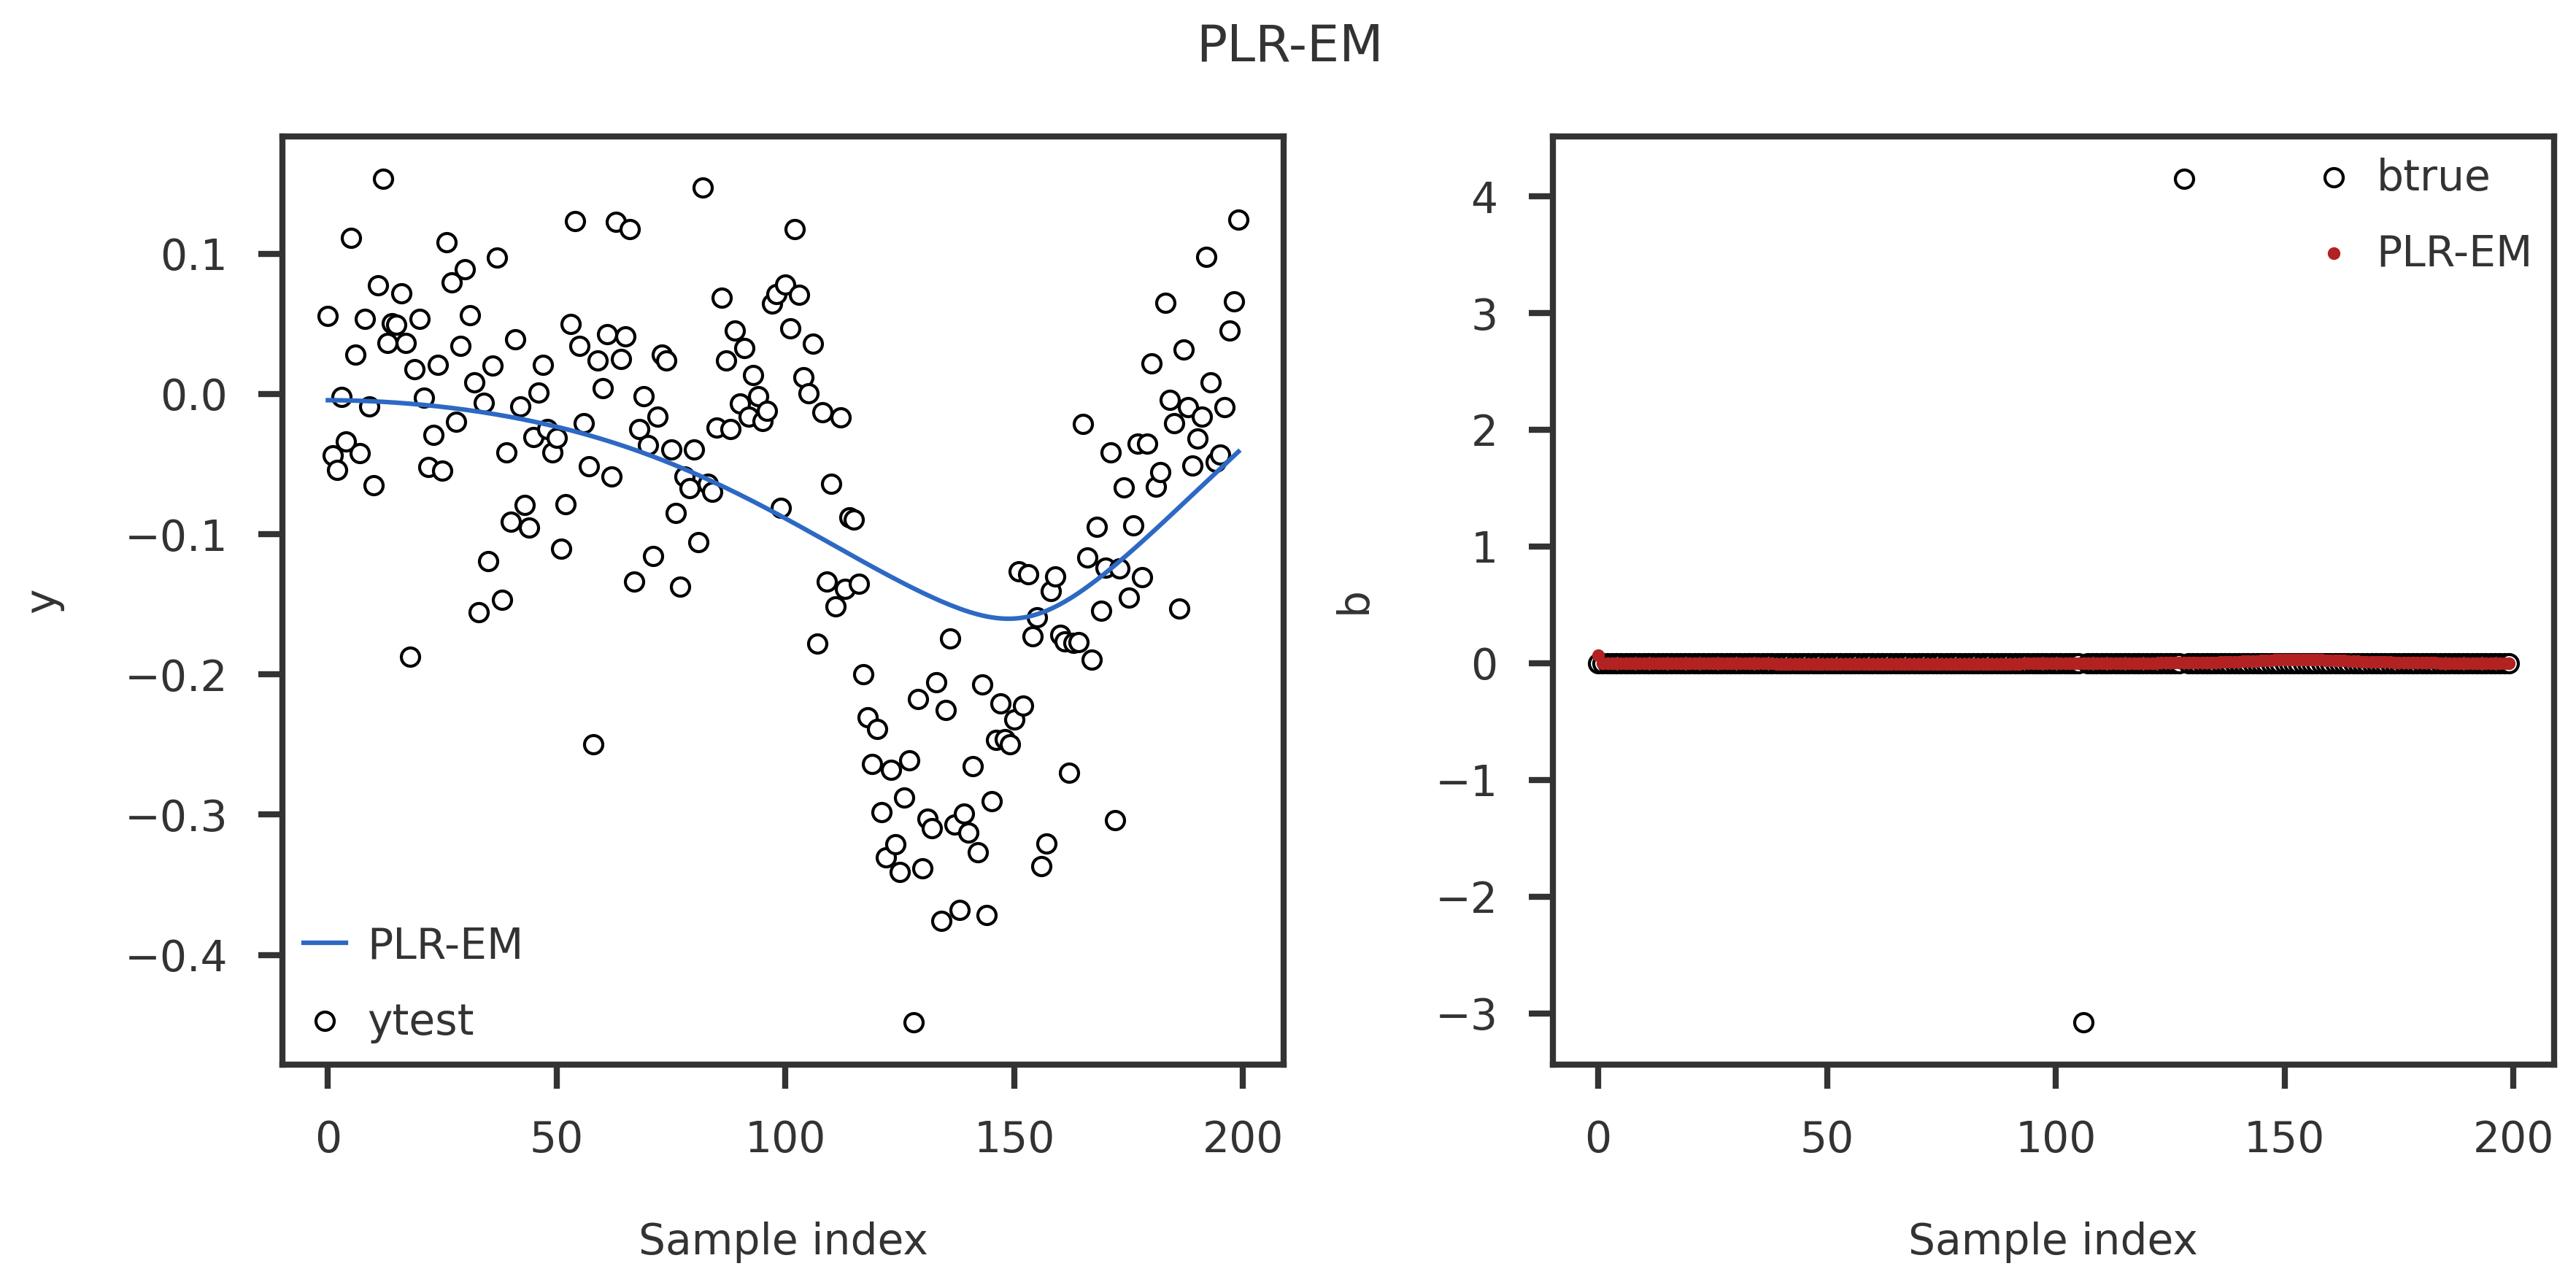

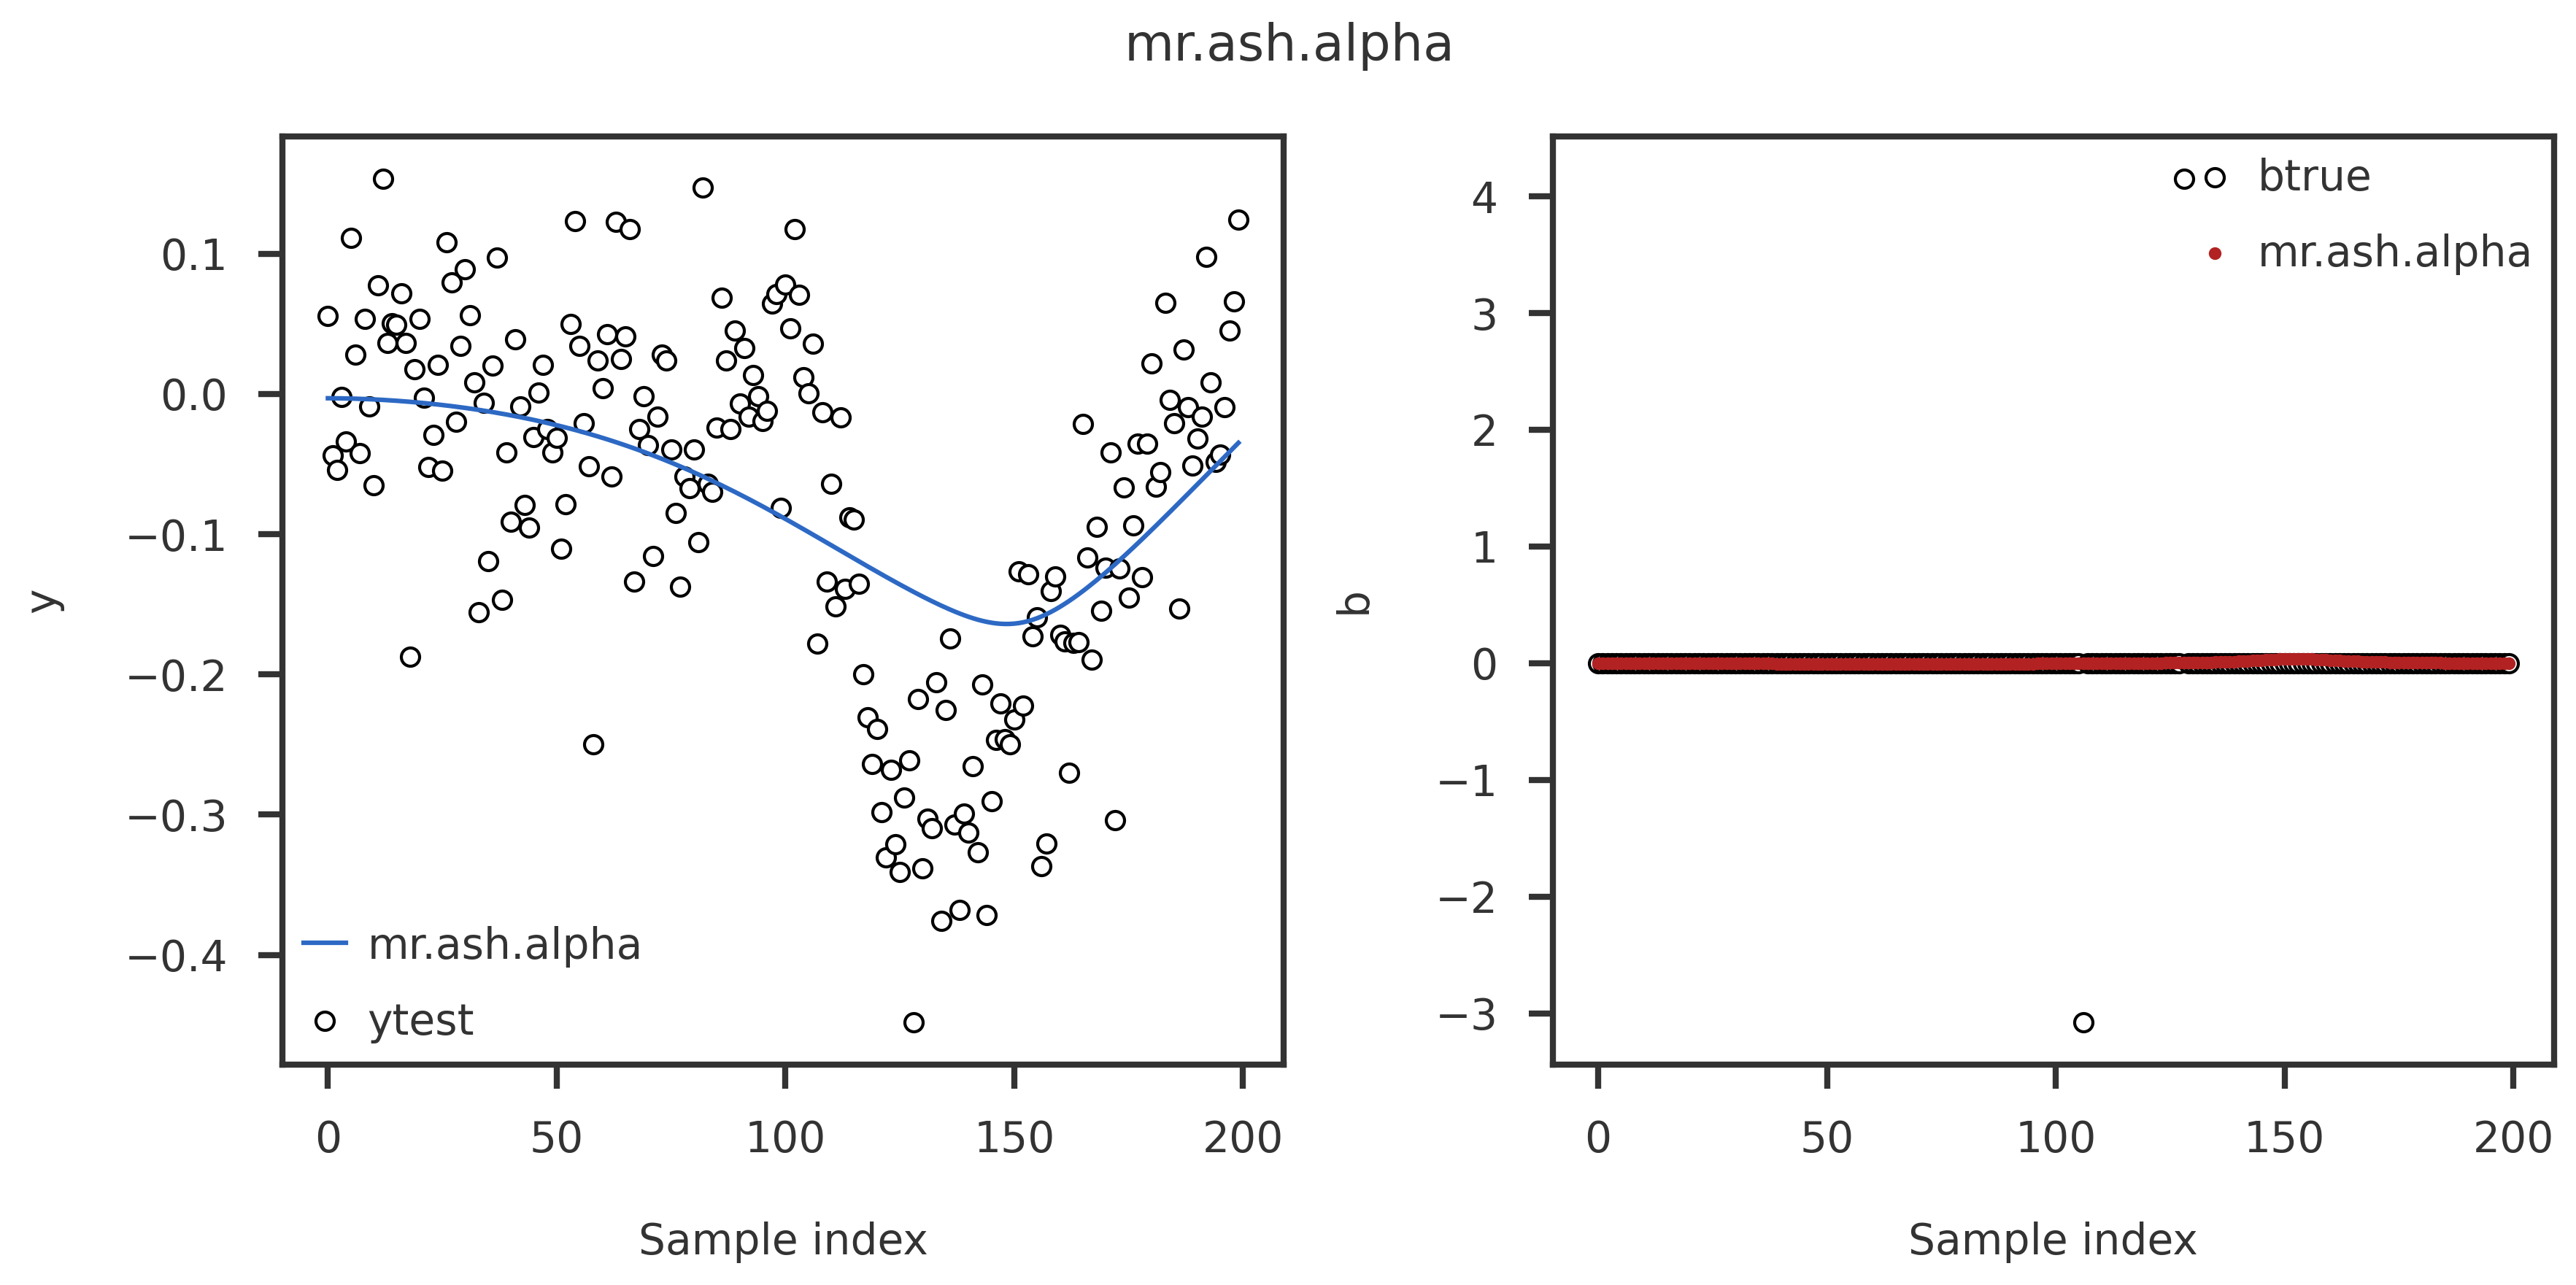

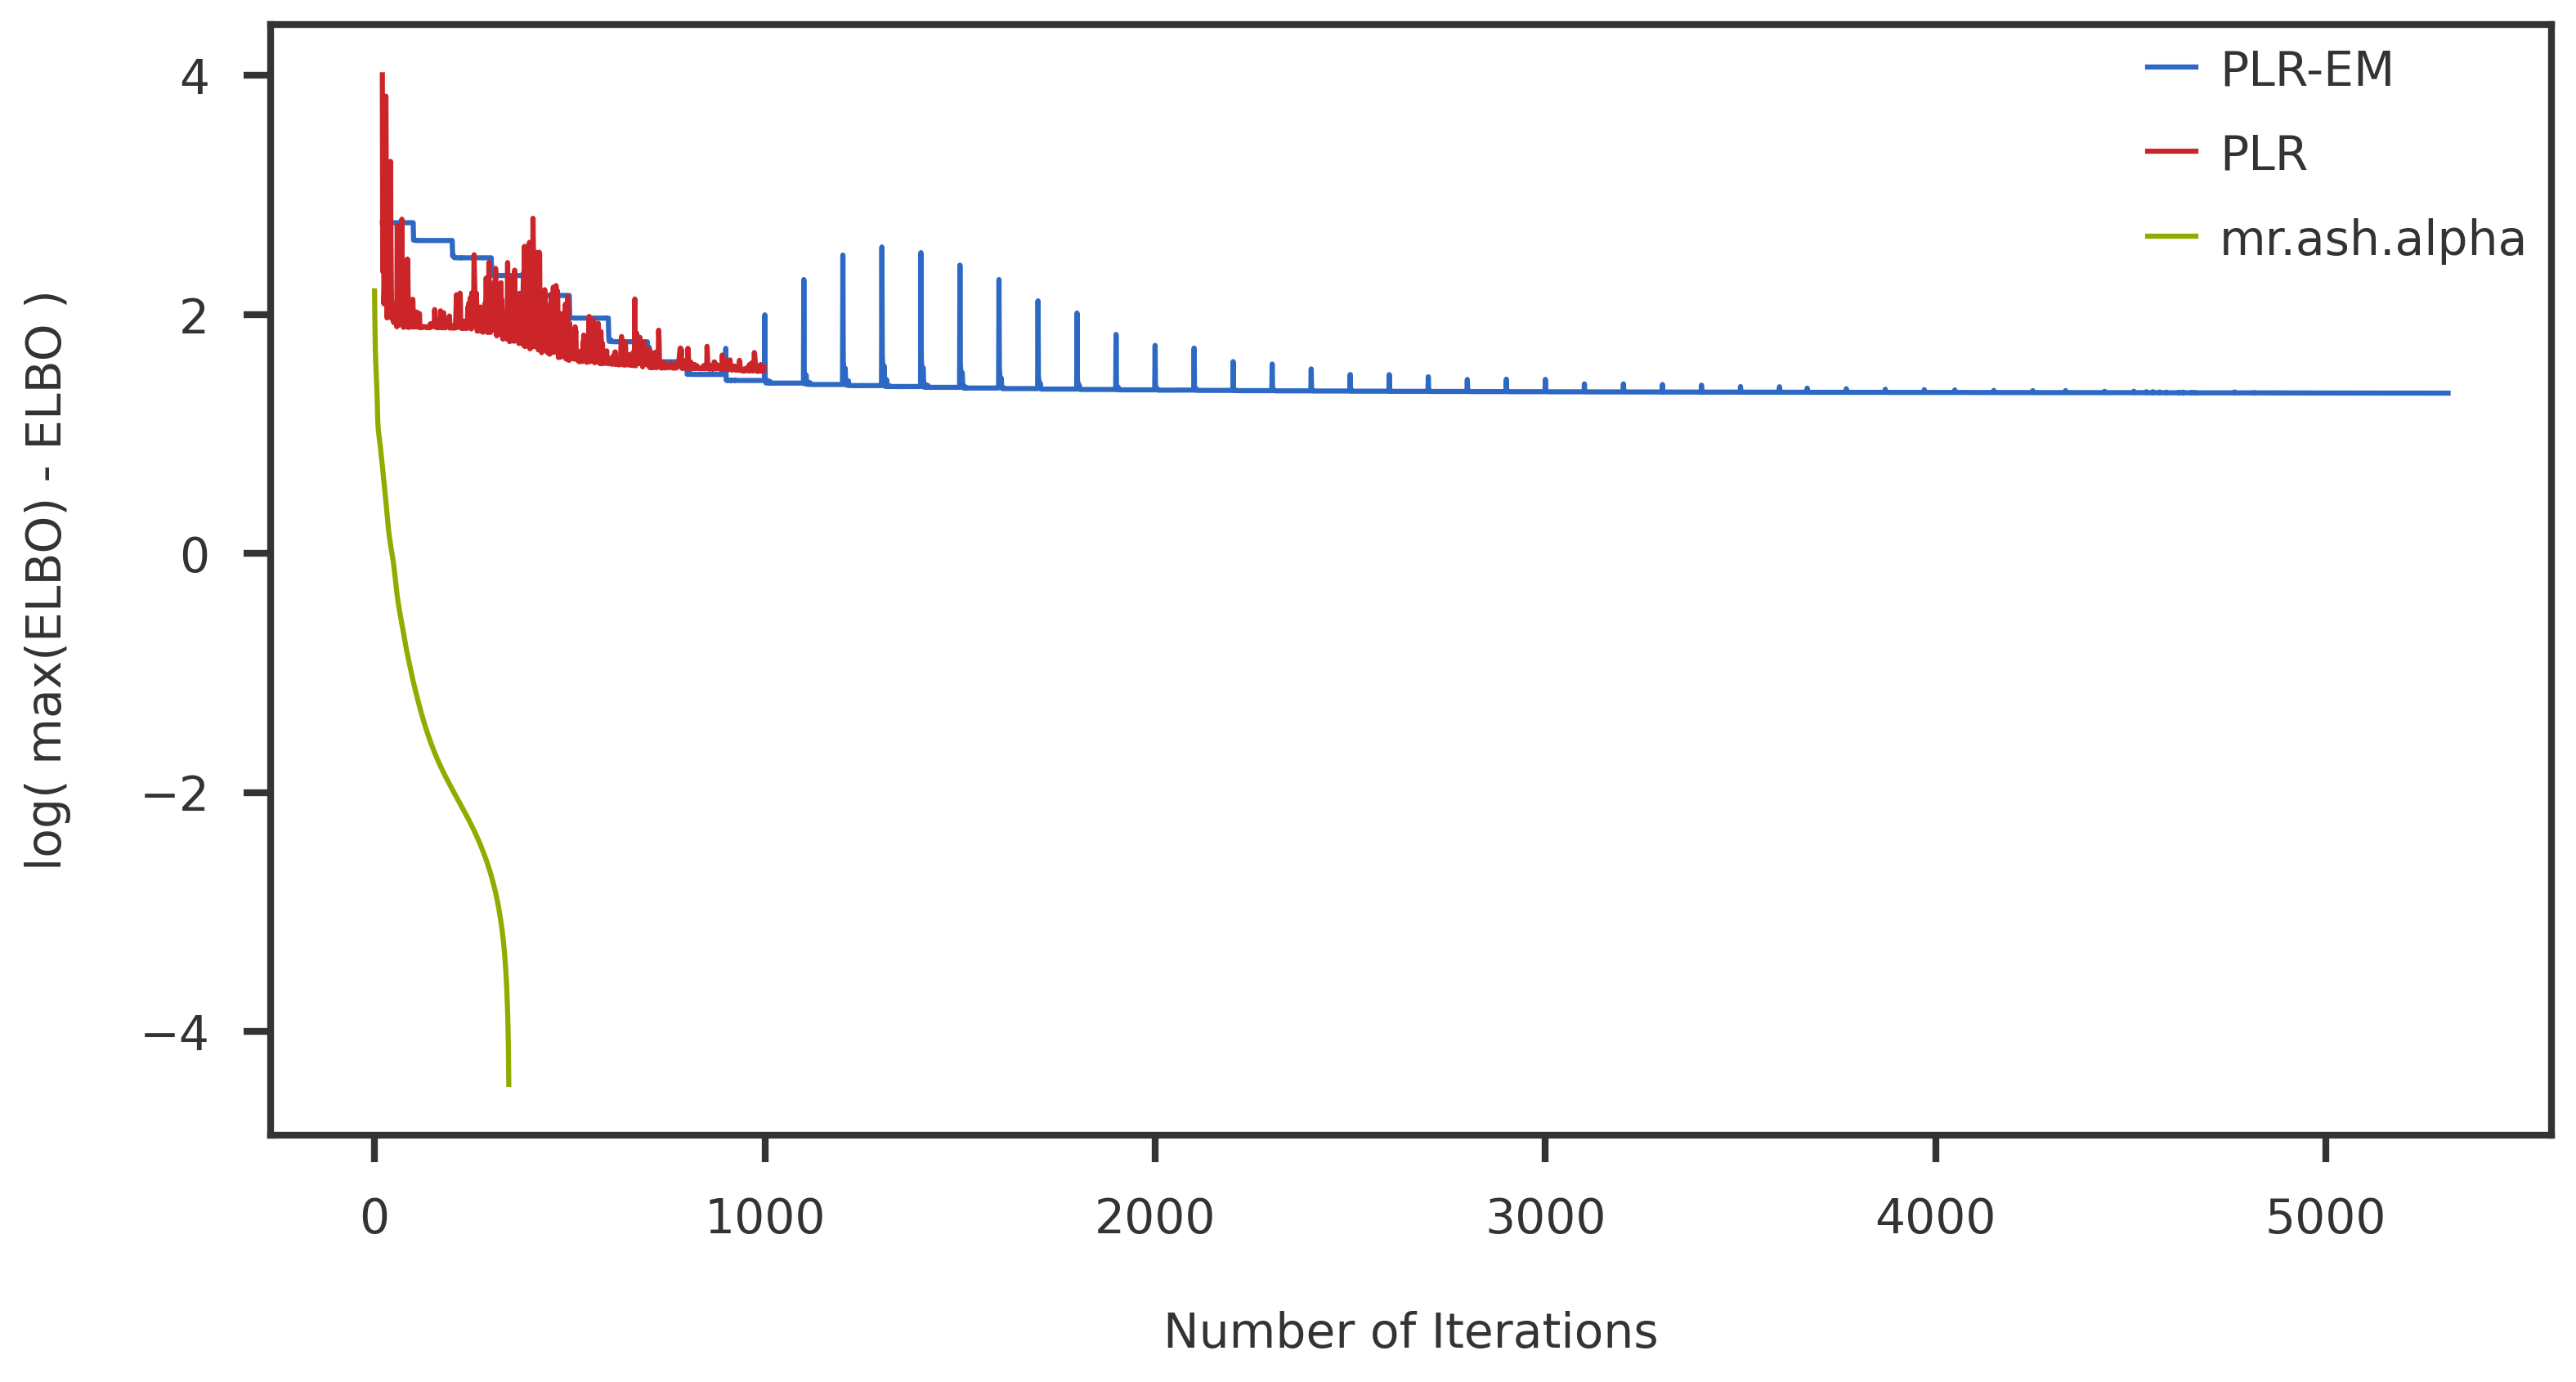

In [9]:
wk, sk = initialize_ash_prior(k, scale = 10)

'''
PLR
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = True, is_prior_scaled = True,
                debug = False, display_progress = False, calculate_elbo = True)
plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = 1)

'''
PLR-EM
'''
plr_eb = ebfit(X, y, sk, wk, binit = None, s2init = 1, maxiter = 200, qb_maxiter = 100)

'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = np.zeros(p), winit = wk, s2init = 1)

'''
Plot
'''
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'PLR')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'PLR-EM')
plot_trendfilter_mrashpen(X, y, btrue, ytest, 
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')

kinit   = [20, 20, 0]
objs    = [plr_eb.elbo_path, plr_lbfgs.elbo_path, mrash_r.obj_path]
methods = ["PLR-EM", "PLR", "mr.ash.alpha"]
plot_convergence(objs, methods, kinit)